# Synthetic data generation with GAN and VAE neural networks for a system of making strategically grounded decisions

## Setup Environment

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
import time
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statistical functions and time-series models
from scipy.stats import (
    boxcox,
    ks_2samp,
    entropy,
    wasserstein_distance,
    chi2_contingency,
)

# Forecasting models
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Machine learning utilities
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)

# String data generation
from faker import Faker

# Project modules
from gan import (
    GAN,
    GanConfig,
    TrainingConfig as GanTrainingConfig,
    SchedulerConfig,
    LossConfig as GanLossConfig,
    FeatureMatchingConfig as GanFeatureMatchingConfig,
    RegularizationConfig as GanRegularizationConfig,
    DeltaConfig as GanDeltaConfig,
    OptimizerConfig as GanOptimizerConfig,
    CovarianceConfig as GanCovarianceConfig,
)
from vae import (
    VAE,
    VaeConfig,
    TrainingConfig as VaeTrainingConfig,
)
from models.enums import DataType
from models.field_metadata import FieldMetadata

## Airline Dataset

In [450]:
airline_dataset = pd.read_csv(
    "datasets/airline-passenger-satisfaction.csv", parse_dates=["Date"]
).dropna()
print(f"Rows count in dataset: {airline_dataset.shape[0]}")
print(f"Column amount: {airline_dataset.shape[1]}")
display(airline_dataset.head(10))

Rows count in dataset: 103594
Column amount: 25


City       Date  Gender      Customer Type  Age   Type of Travel  \
0       Austin 2019-07-13    Male     Loyal Customer   13  Personal Travel   
1     San Jose 2017-07-26    Male  disloyal Customer   25  Business travel   
2      Seattle 2018-08-27  Female     Loyal Customer   26  Business travel   
3  San Antonio 2018-04-21  Female     Loyal Customer   25  Business travel   
4       Austin 2019-05-30    Male     Loyal Customer   61  Business travel   
5      Seattle 2018-09-23  Female     Loyal Customer   26  Personal Travel   
6       Dallas 2019-09-21    Male     Loyal Customer   47  Personal Travel   
7       Austin 2018-07-12  Female     Loyal Customer   52  Business travel   
8       Denver 2019-03-08  Female     Loyal Customer   41  Business travel   
9       Denver 2019-10-14    Male  disloyal Customer   20  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   
5       Eco             1180                      3   
6       Eco             1276                      2   
7  Business             2035                      4   
8  Business              853                      1   
9       Eco             1061                      3   

   Departure or Arrival time convenient  ...  Inflight entertainment  \
0                                     4  ...                       5   
1                                     2  ...                       1   
2                                     2  ...                       5   
3                                     5  ...                       2   
4                                     3  ...                       3   
5                                     4  ...                       1   
6                                     4  ...                       2   
7                                     3  ...                       5   
8                                     2  ...                       1   
9                                     3  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   
5                 3                 4                 4                4   
6                 3                 3                 4                3   
7                 5                 5                 5                4   
8                 1                 2                 1                4   
9                 2                 3                 4                4   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   
5                 4            1                           0   
6                 5            2                           9   
7                 5            4                           4   
8                 1            2                           0   
9                 3            2                           0   

   Arrival Delay in Minutes  is_satisfied  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0       

### Overview of dataset column info

In [451]:
print(airline_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   City                                  103594 non-null  object        
 1   Date                                  103594 non-null  datetime64[ns]
 2   Gender                                103594 non-null  object        
 3   Customer Type                         103594 non-null  object        
 4   Age                                   103594 non-null  int64         
 5   Type of Travel                        103594 non-null  object        
 6   Class                                 103594 non-null  object        
 7   Flight Distance                       103594 non-null  int64         
 8   Inflight wifi service                 103594 non-null  int64         
 9   Departure or Arrival time convenient  103594 non-null  int64    

### Synthetic Data Generation

#### Metadata for GAN and VAE networks, that describe types of data and methods of their generation

In [452]:
airline_metadata = {
    "City": FieldMetadata(DataType.STRING, faker_method=Faker().city),
    "Date": FieldMetadata(DataType.DATETIME, datetime_format="%Y-%m-%d"),
    "Gender": FieldMetadata(DataType.CATEGORICAL),
    "Customer Type": FieldMetadata(DataType.CATEGORICAL),
    "Age": FieldMetadata(DataType.INTEGER),
    "Type of Travel": FieldMetadata(DataType.CATEGORICAL),
    "Class": FieldMetadata(DataType.CATEGORICAL),
    "Flight Distance": FieldMetadata(DataType.INTEGER),
    "Inflight wifi service": FieldMetadata(DataType.INTEGER),
    "Departure or Arrival time convenient": FieldMetadata(DataType.INTEGER),
    "Ease of Online booking": FieldMetadata(DataType.INTEGER),
    "Gate location": FieldMetadata(DataType.INTEGER),
    "Food and drink": FieldMetadata(DataType.INTEGER),
    "Online boarding": FieldMetadata(DataType.INTEGER),
    "Seat comfort": FieldMetadata(DataType.INTEGER),
    "Inflight entertainment": FieldMetadata(DataType.INTEGER),
    "On-board service": FieldMetadata(DataType.INTEGER),
    "Leg room service": FieldMetadata(DataType.INTEGER),
    "Baggage handling": FieldMetadata(DataType.INTEGER),
    "Checkin service": FieldMetadata(DataType.INTEGER),
    "Inflight service": FieldMetadata(DataType.INTEGER),
    "Cleanliness": FieldMetadata(DataType.INTEGER),
    "Departure Delay in Minutes": FieldMetadata(DataType.INTEGER),
    "Arrival Delay in Minutes": FieldMetadata(DataType.DECIMAL, decimal_places=1),
    "is_satisfied": FieldMetadata(DataType.BOOLEAN),
}

#### Define lists of columns by type for statistical analysis after data generation

In [453]:
airline_num_cols = [
    col
    for col, meta in airline_metadata.items()
    if meta.data_type in {DataType.INTEGER, DataType.DECIMAL}
]
airline_cat_cols = [
    col
    for col, meta in airline_metadata.items()
    if meta.data_type in {DataType.CATEGORICAL, DataType.BOOLEAN}
]
airline_datetime_cols = [
    col for col, meta in airline_metadata.items() if meta.data_type == DataType.DATETIME
]
airline_string_cols = [
    col for col, meta in airline_metadata.items() if meta.data_type == DataType.STRING
]

#### Training process of GAN and VAE networks

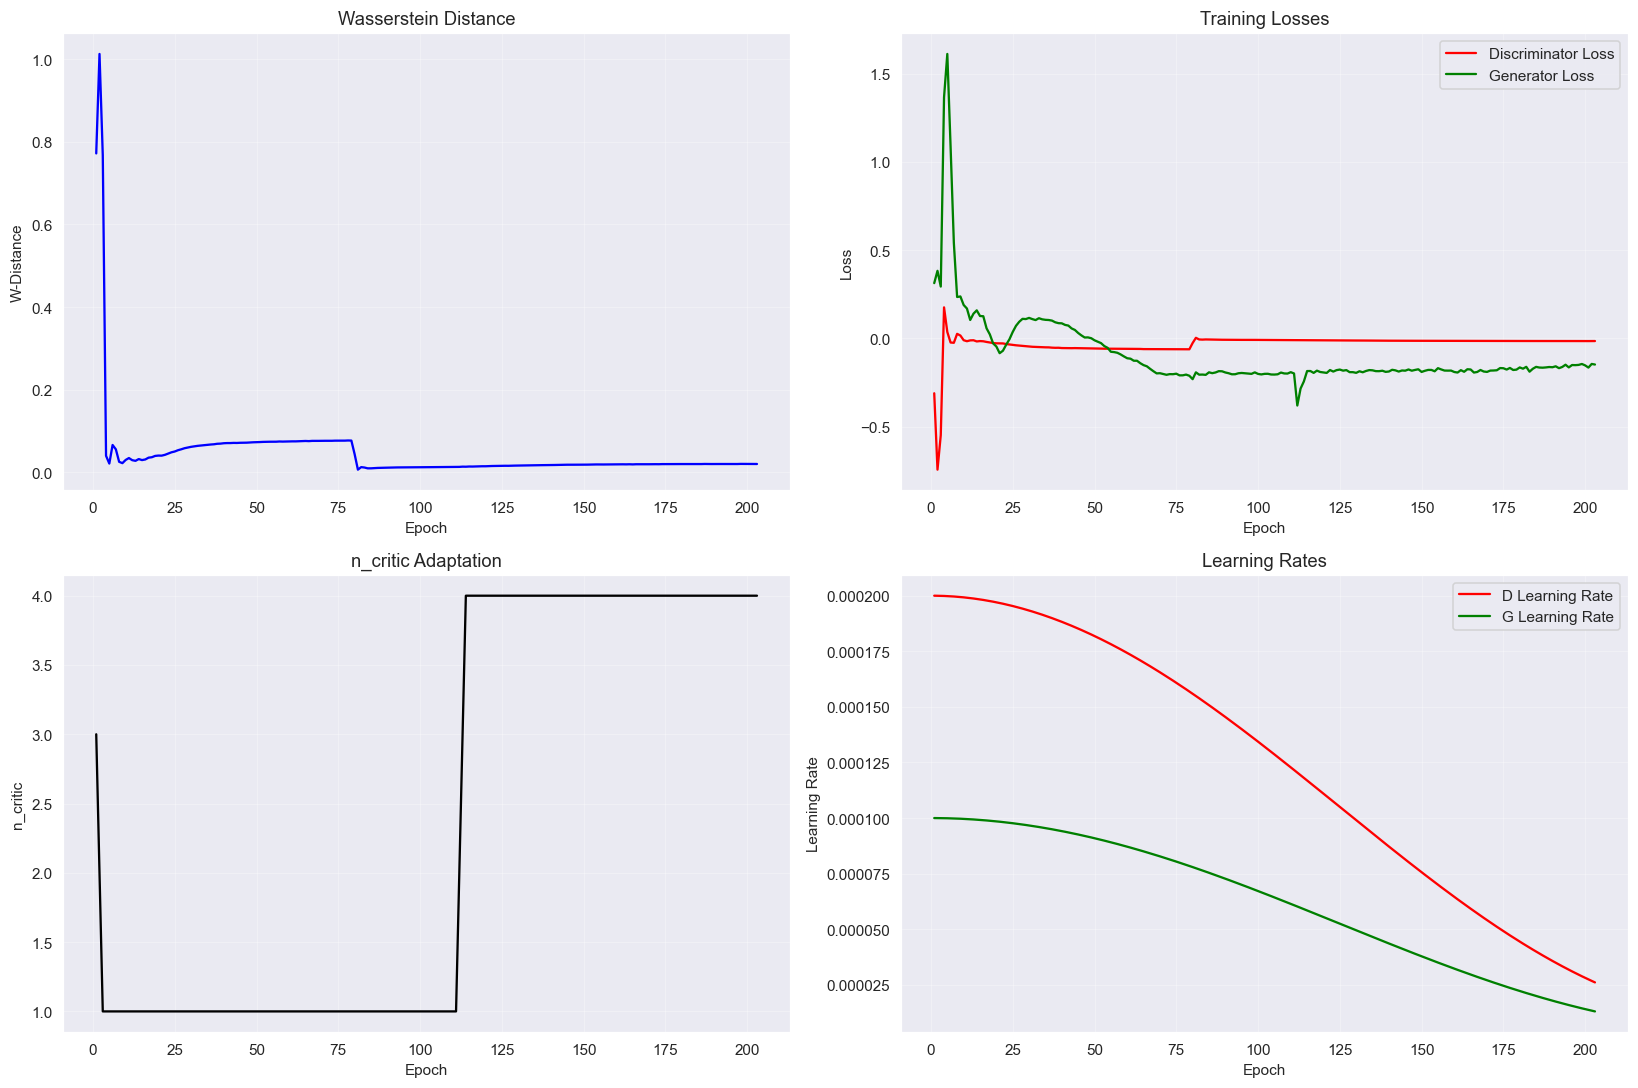

Training completed in 1861.17 seconds


In [454]:
start_time = time.time()

cfg = GanConfig(
    training=GanTrainingConfig(epochs=250, verbose=True),
    scheduler=SchedulerConfig(patience=200),
)
# Creating a GAN pipeline with GAN Config class
gan_model = GAN(airline_dataset, airline_metadata, cfg)
# Training a GAN model with training plots
gan_model.fit()
# Generating synthetic data
airline_gan_dataset = gan_model.generate(len(airline_dataset) // 2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

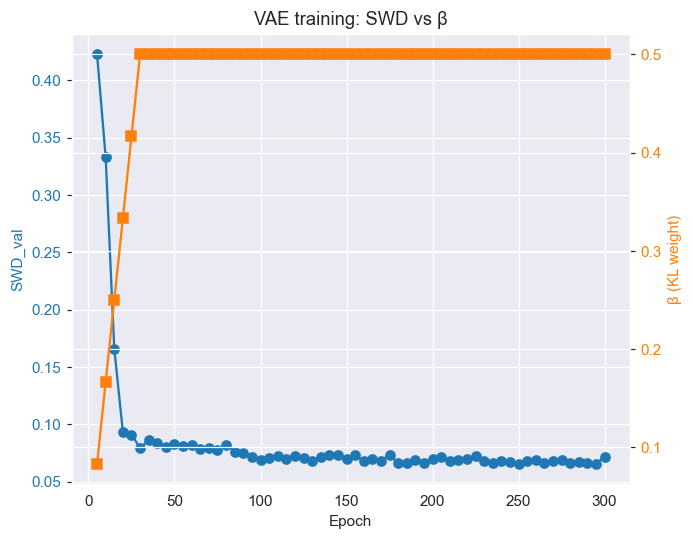

Training completed in 2656.14 seconds


In [455]:
warnings.simplefilter("ignore", UserWarning)
start_time = time.time()
# Creating a VAE pipeline
vae_model = VAE(
    airline_dataset,
    airline_metadata,
    VaeConfig(training=VaeTrainingConfig(epochs=300, verbose=True)),
)
# Training a VAE model with training plots
vae_model.fit()
# Generating synthetic data
airline_vae_dataset = vae_model.generate(len(airline_dataset) // 2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

### Quality Analysis

#### Original dataset - numeric columns

In [456]:
display(airline_dataset[airline_num_cols].describe())

Age  Flight Distance  Inflight wifi service  \
count  103594.000000    103594.000000          103594.000000   
mean       39.380466      1189.325202               2.729753   
std        15.113125       997.297235               1.327866   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       842.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure or Arrival time convenient  Ease of Online booking  \
count                         103594.000000           103594.000000   
mean                               3.060081                2.756984   
std                                1.525233                1.398934   
min                                0.000000                0.000000   
25%                                2.000000                2.000000   
50%                                3.000000                3.000000   
75%                                4.000000                4.000000   
max                                5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103594.000000             103594.000000  
mean                    14.747939                 15.178678  
std                     38.116737                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

#### Statistical metrics of synthetic and original dataset

##### Utility Methods for statistic comparison

In [457]:
def _kl_divergence(hist_ref, hist_cmp, eps=1e-10):
    """Symmetric KL with smoothing to avoid log(0)"""
    return 0.5 * (
        entropy(hist_ref + eps, hist_cmp + eps)
        + entropy(hist_cmp + eps, hist_ref + eps)
    )


def _value_counts(series):
    """Consistent index type (str) so union / reindex is stable."""
    return series.astype("object").astype(str).value_counts()

##### Statistical comparison of numeric fields in two synthetic datasets

In [473]:
numeric_metrics = []

for col, meta in airline_metadata.items():
    if col not in airline_num_cols:
        continue

    real = airline_dataset[col].to_numpy()
    gan = airline_gan_dataset[col].to_numpy()
    vae = airline_vae_dataset[col].to_numpy()

    # histogram on real data
    edges = np.histogram_bin_edges(real, bins="auto")

    # cap bin count at 200
    if len(edges) - 1 > 200:
        edges = np.linspace(real.min(), real.max(), 201)

    # build the histogram
    hist_r, bins = np.histogram(real, bins=edges, density=True)

    # extract derived info
    n_bins = len(bins) - 1
    bin_width = bins[1] - bins[0]

    # Wasserstein (raw and in bins)
    w_gan = wasserstein_distance(real, gan)
    w_vae = wasserstein_distance(real, vae)

    # KS test
    ks_gan = ks_2samp(real, gan)
    ks_vae = ks_2samp(real, vae)

    # KL divergence over the same bins
    hist_g, _ = np.histogram(gan, bins=bins, density=True)
    hist_v, _ = np.histogram(vae, bins=bins, density=True)
    kl_gan = _kl_divergence(hist_r, hist_g)
    kl_vae = _kl_divergence(hist_r, hist_v)

    numeric_metrics.append(
        {
            "field": col,
            "n_bins": n_bins,
            "bin_width": bin_width,
            "W_gan": w_gan,
            "KS_gan_stat": ks_gan.statistic,
            "KL_gan": kl_gan,
            "W_vae": w_vae,
            "KS_vae_stat": ks_vae.statistic,
            "KL_vae": kl_vae,
        }
    )

display(pd.DataFrame(numeric_metrics).set_index("field").sort_index())

n_bins  bin_width      W_gan  \
field                                                                
Age                                       77   1.012987   0.438520   
Arrival Delay in Minutes                 200   7.920000   0.799950   
Baggage handling                           4   1.000000   0.047271   
Checkin service                            5   1.000000   0.102419   
Cleanliness                                5   1.000000   0.029567   
Departure Delay in Minutes               200   7.960000   0.670521   
Departure or Arrival time convenient       5   1.000000   0.062378   
Ease of Online booking                     5   1.000000   0.042194   
Flight Distance                           88  56.272727  53.198245   
Food and drink                             5   1.000000   0.020995   
Gate location                              5   1.000000   0.044346   
Inflight entertainment                     5   1.000000   0.033670   
Inflight service                           5   1.000000   0.060052   
Inflight wifi service                      5   1.000000   0.038574   
Leg room service                           5   1.000000   0.092544   
On-board service                           5   1.000000   0.058864   
Online boarding                            5   1.000000   0.057339   
Seat comfort                               5   1.000000   0.034568   

                                      KS_gan_stat    KL_gan      W_vae  \
field                                                                    
Age                                      0.015522  0.023895   0.306524   
Arrival Delay in Minutes                 0.051383  0.019353   4.100295   
Baggage handling                         0.018466  0.003086   0.142045   
Checkin service                          0.033834  0.005303   0.075120   
Cleanliness                              0.011593  0.002030   0.136987   
Departure Delay in Minutes               0.050447  0.018228   4.202599   
Departure or Arrival time convenient     0.021208  0.006498   0.174856   
Ease of Online booking                   0.015899  0.004158   0.202357   
Flight Distance                          0.033371  0.013556  11.718661   
Food and drink                           0.012481  0.009291   0.146273   
Gate location                            0.018322  0.002325   0.124177   
Inflight entertainment                   0.018621  0.001892   0.219260   
Inflight service                         0.020966  0.002990   0.140076   
Inflight wifi service                    0.012385  0.003811   0.234106   
Leg room service                         0.029838  0.003046   0.143358   
On-board service                         0.022405  0.003000   0.143811   
Online boarding                          0.017260  0.001984   0.165067   
Seat comfort                             0.015908  0.001727   0.160830   

                                      KS_vae_stat    KL_vae  
field                                                        
Age                                      0.010560  0.025169  
Arrival Delay in Minutes                 0.070323  0.023382  
Baggage handling                         0.056461  0.008612  
Checkin service                          0.032454  0.002681  
Cleanliness                              0.044800  0.010407  
Departure Delay in Minutes               0.073576  0.023475  
Departure or Arrival time convenient     0.059859  0.019591  
Ease of Online booking                   0.056635  0.028721  
Flight Distance                          0.013765  0.005068  
Food and drink                           0.049646  0.018674  
Gate location                            0.042280  0.009816  
Inflight entertainment                   0.078219  0.026553  
Inflight service                         0.056248  0.008290  
Inflight wifi service                    0.071442  0.040137  
Leg room service                         0.048043  0.008950  
On-board service                         0.050949  0.007848  
Online boarding                         

KS stat: maximum difference between the empirical CDFs of real and synthetic data (acceptable if < 10%)

KL: Kullback–Leibler divergence between the histograms of real and synthetic data, measuring average information loss when replacing real with synthetic (acceptable if < 10%)

##### Statistical comparison of categorical fields in two synthetic datasets

In [474]:
categorical_metrics = []


def cramers_v(counts_a, counts_b):
    """Cramér’s V between two count vectors (size-independent)."""
    cont = np.vstack([counts_a, counts_b])
    chi2, _, _, _ = chi2_contingency(cont, correction=False)
    n = cont.sum()
    k = cont.shape[1]
    return np.sqrt(chi2 / (n * max(k - 1, 1)))


for col, meta in airline_metadata.items():
    if col not in airline_cat_cols:
        continue

    real_ct = _value_counts(airline_dataset[col])
    gan_ct = _value_counts(airline_gan_dataset[col])
    vae_ct = _value_counts(airline_vae_dataset[col])

    cats = sorted(set(real_ct.index) | set(gan_ct.index) | set(vae_ct.index))
    r = real_ct.reindex(cats, fill_value=0)
    g = gan_ct.reindex(cats, fill_value=0)
    v = vae_ct.reindex(cats, fill_value=0)

    # scale-free metrics
    r_prop, g_prop, v_prop = r / r.sum(), g / g.sum(), v / v.sum()

    mae_prop_gan = mean_absolute_error(r_prop, g_prop)
    mae_prop_vae = mean_absolute_error(r_prop, v_prop)

    jsd_gan = 0.5 * (
        entropy(r_prop, 0.5 * (r_prop + g_prop))
        + entropy(g_prop, 0.5 * (r_prop + g_prop))
    )
    jsd_vae = 0.5 * (
        entropy(r_prop, 0.5 * (r_prop + v_prop))
        + entropy(v_prop, 0.5 * (r_prop + v_prop))
    )

    v_gan = cramers_v(r, g)
    v_vae = cramers_v(r, v)

    categorical_metrics.append(
        {
            "field": col,
            "MAE_prop_gan": mae_prop_gan,
            "MAE_prop_vae": mae_prop_vae,
            "JSD_gan": jsd_gan,
            "JSD_vae": jsd_vae,
            "CramersV_gan": v_gan,
            "CramersV_vae": v_vae,
        }
    )

df_metrics = pd.DataFrame(categorical_metrics).set_index("field").sort_index()
display(df_metrics)

MAE_prop_gan  MAE_prop_vae       JSD_gan   JSD_vae  \
field                                                                
Class               0.001487      0.022395  3.012552e-06  0.002742   
Customer Type       0.002182      0.021082  4.001886e-06  0.000390   
Gender              0.000695      0.005290  2.415768e-07  0.000014   
Type of Travel      0.004257      0.023679  1.054802e-05  0.000335   
is_satisfied        0.002037      0.007925  2.112924e-06  0.000032   

                CramersV_gan  CramersV_vae  
field                                       
Class               0.001636      0.046837  
Customer Type       0.002665      0.026113  
Gender              0.000655      0.004988  
Type of Travel      0.004333      0.024307  
is_satisfied        0.001938      0.007534

MAE_prop – mean absolute error between category proportions in synthetic vs real data(acceptable when <0.02)

JSD – Jensen–Shannon divergence measuring distribution similarity between synthetic and real categories. Calculated as average of 2 KL-divergences to their average distribution (acceptable when <0.02)

Cramér’s V – normalized measure of association strength between synthetic and real category frequencies (acceptable when <0.1)

##### Analytics on string data type generation

In [460]:
orig_names = airline_dataset["City"].value_counts().nlargest(20).index.tolist()
gan_names = airline_gan_dataset["City"].value_counts().nlargest(20).index.tolist()
vae_names = airline_vae_dataset["City"].value_counts().nlargest(20).index.tolist()

max_len = 20


def pad(lst):
    return lst + [None] * (max_len - len(lst))


data = {"Original": pad(orig_names), "GAN": pad(gan_names), "VAE": pad(vae_names)}

df = pd.DataFrame(data)
df.index = range(1, max_len + 1)
df.index.name = f"Rank"
display(df)

Original               GAN               VAE
Rank                                                   
1            Denver      Lake Michael      West Michael
2      Indianapolis      Port Michael     South Michael
3           Seattle      West Michael      Lake Michael
4          San Jose      East Michael      Port Michael
5          Columbus     South Michael     North Michael
6         Charlotte      Michaelmouth        West James
7        Washington         West John          New John
8       San Antonio         New David      East Michael
9      Jacksonville        Port David         New David
10        San Diego       North James       North James
11         New York         Lake John        South John
12    San Francisco     North Michael        West David
13          Chicago       East Robert  Port Christopher
14          Houston  Lake Christopher        Port James
15      Los Angeles        New Robert      South Robert
16     Philadelphia        East David      Michaelmouth
17           Austin       New Michael         Lake John
18          Phoenix        Smithmouth        Port David
19           Dallas  West Christopher       East Robert
20       Fort Worth  East Christopher       New Michael

##### Distributions comparison of numeric columns

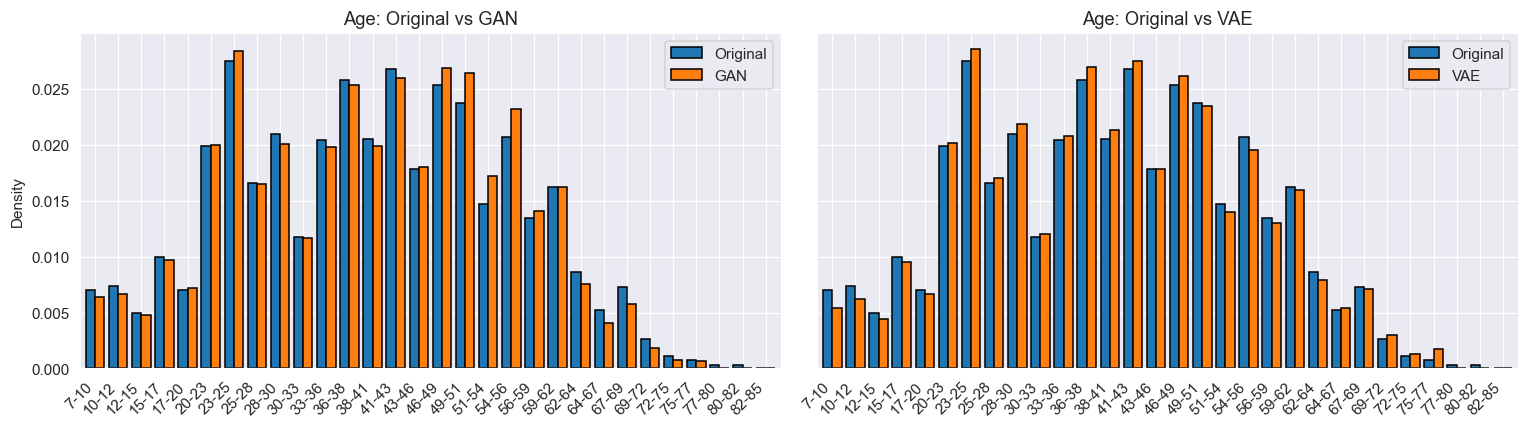

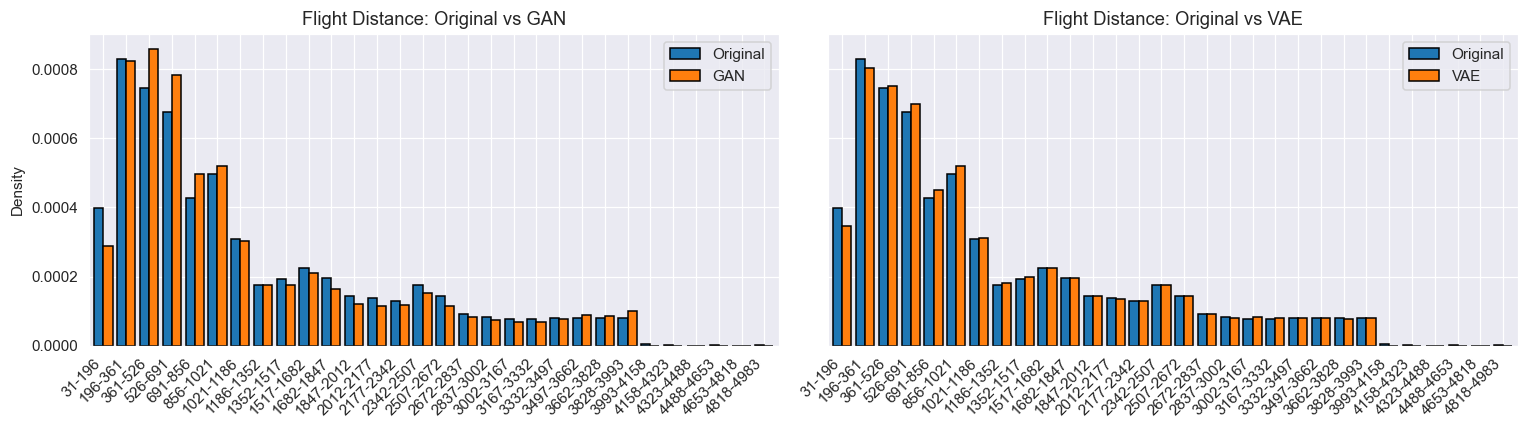

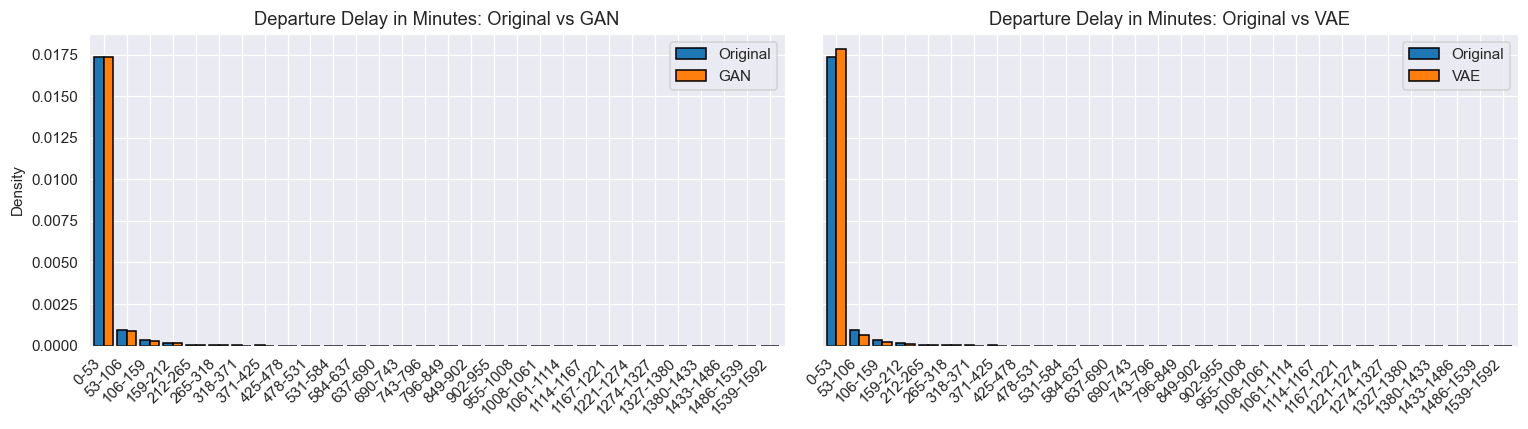

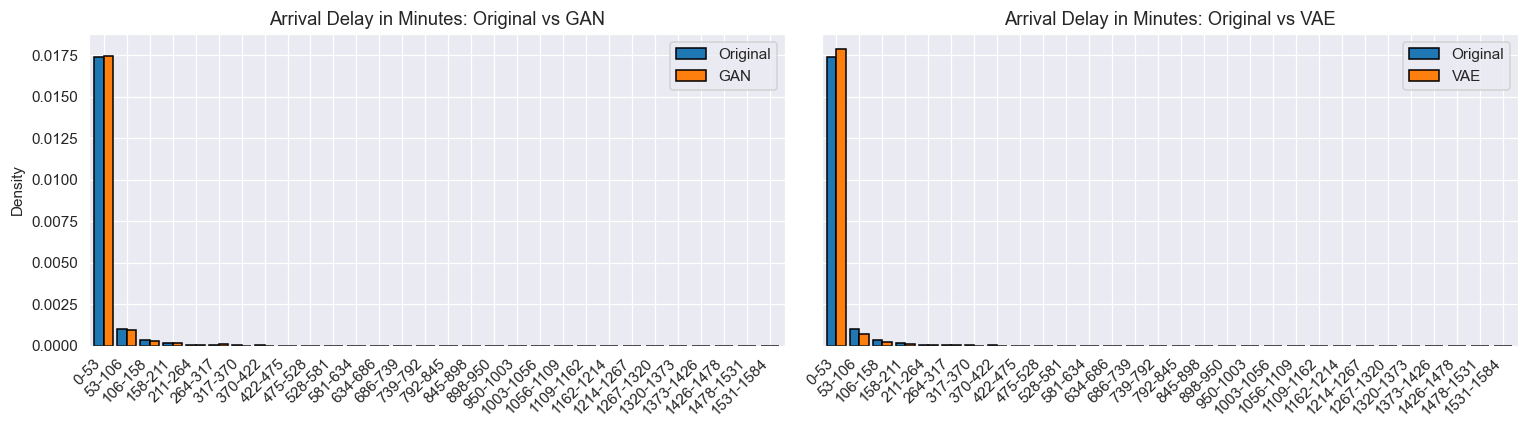

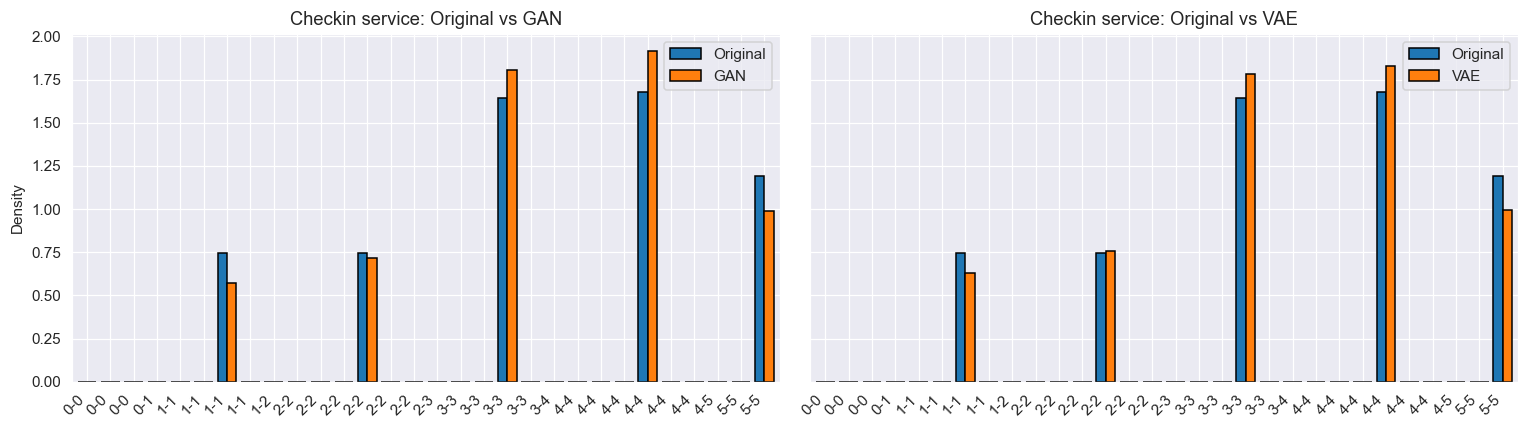

In [461]:
for col in [
    "Age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
    "Checkin service",
]:
    orig_vals = airline_dataset[col].dropna().values
    gan_vals = airline_gan_dataset[col].dropna().values
    vae_vals = airline_vae_dataset[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts, _ = np.histogram(gan_vals, bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins) - 1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({"Original": orig_counts, "GAN": gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({"Original": orig_counts, "VAE": vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind="bar", ax=axes[0], width=0.8, edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Density")

    df_ov.plot(kind="bar", ax=axes[1], width=0.8, edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.legend()
    plt.tight_layout()
    plt.show()

##### Distributions comparison of categorical columns

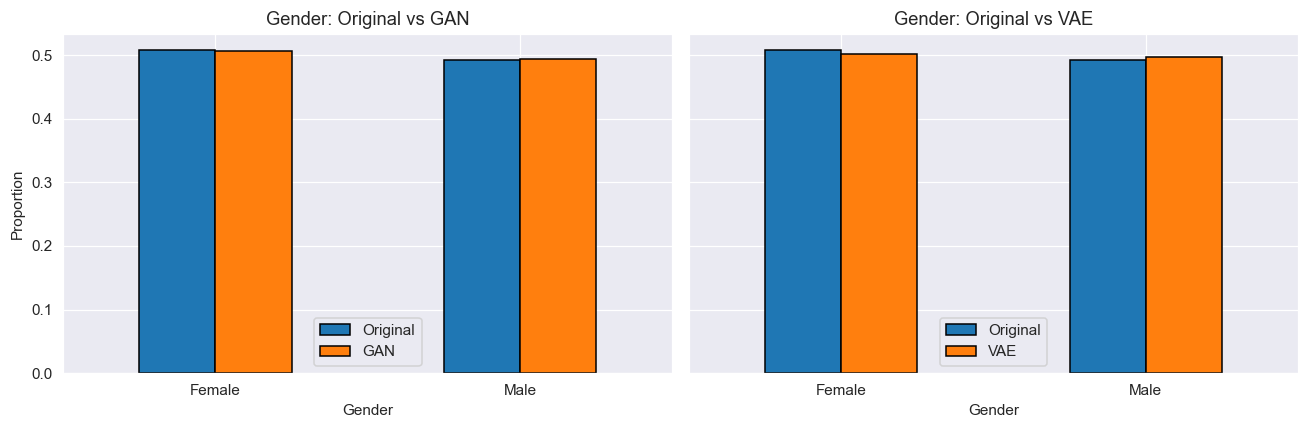

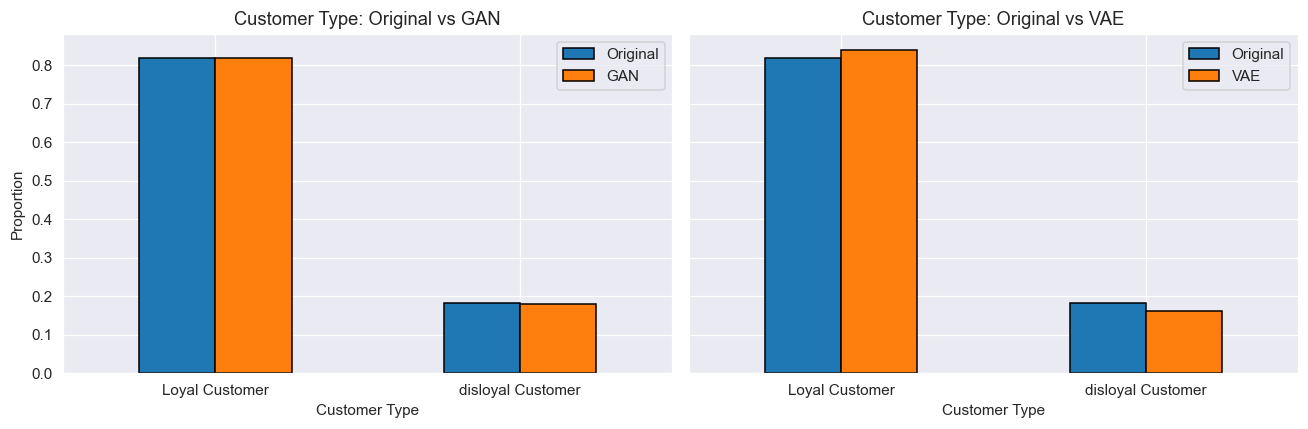

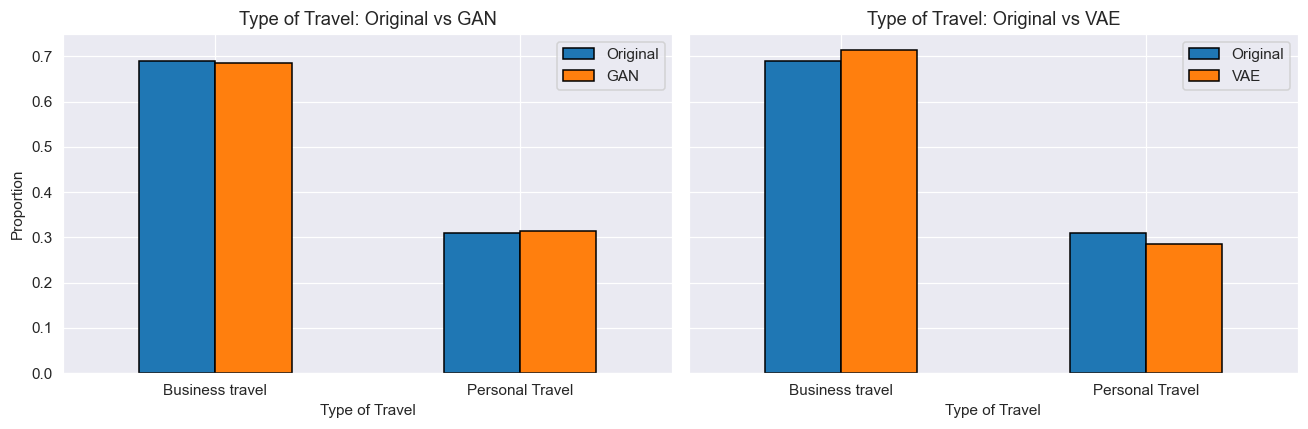

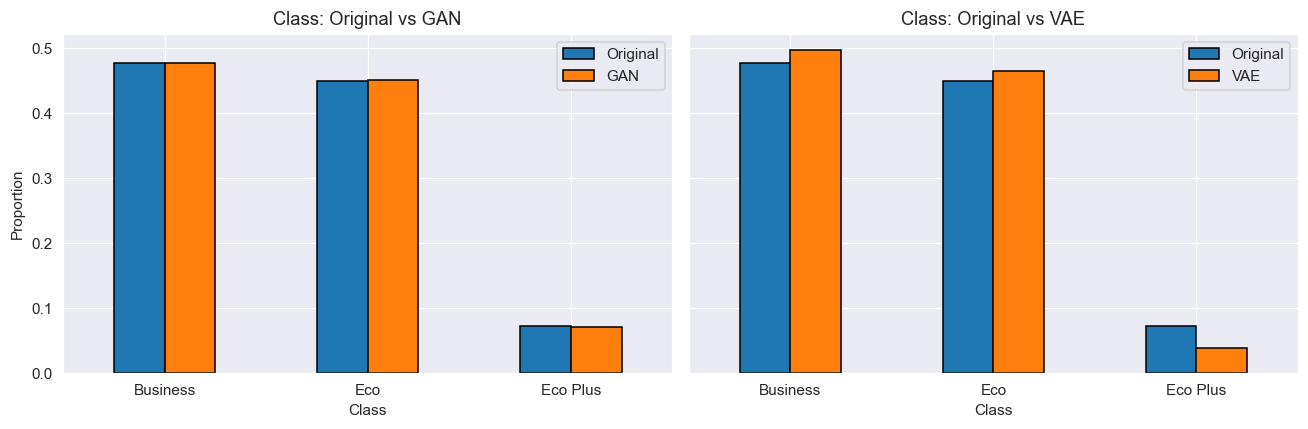

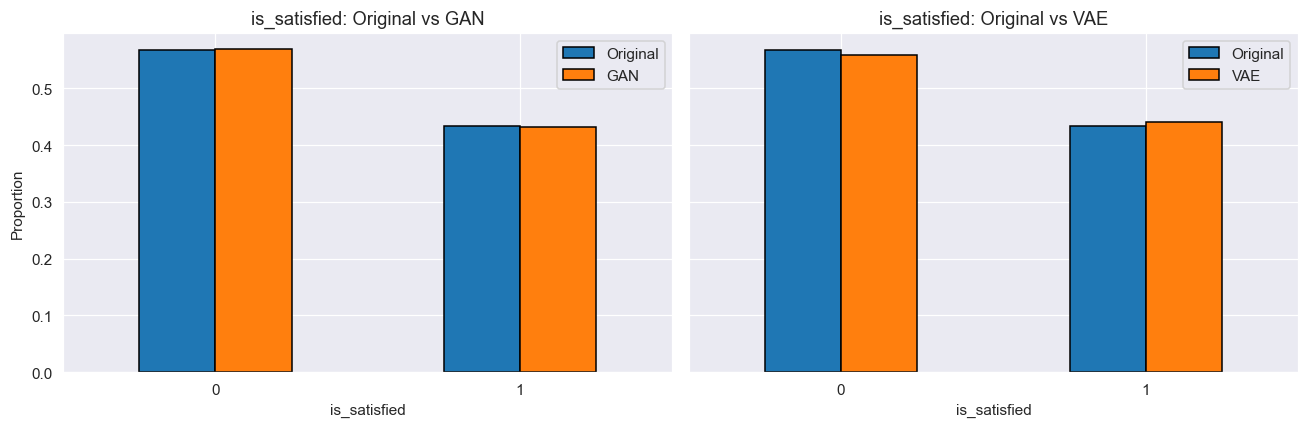

In [462]:
for col in airline_cat_cols:
    # Prepare normalized proportions as strings to avoid mixed-type ordering issues
    orig = (
        airline_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .sort_index()
    )
    gan = (
        airline_gan_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .reindex(orig.index, fill_value=0)
    )
    vae = (
        airline_vae_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .reindex(orig.index, fill_value=0)
    )

    # Build DataFrames for side-by-side bar plots
    df_gan_counts = pd.DataFrame({"Original": orig, "GAN": gan})
    df_vae_counts = pd.DataFrame({"Original": orig, "VAE": vae})

    # Create 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot Original vs GAN
    df_gan_counts.plot(kind="bar", ax=axes[0], edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Proportion")

    # Plot Original vs VAE
    df_vae_counts.plot(kind="bar", ax=axes[1], edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    # Tidy up tick labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()

    plt.tight_layout()
    plt.show()

##### Distributions comparison of datetime columns

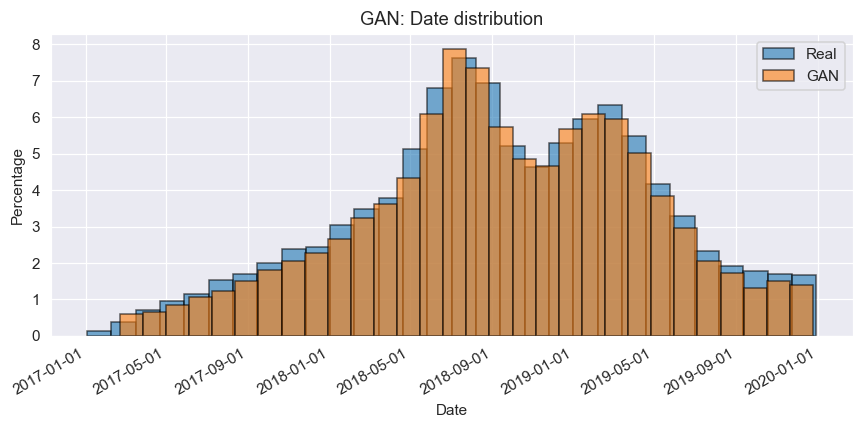

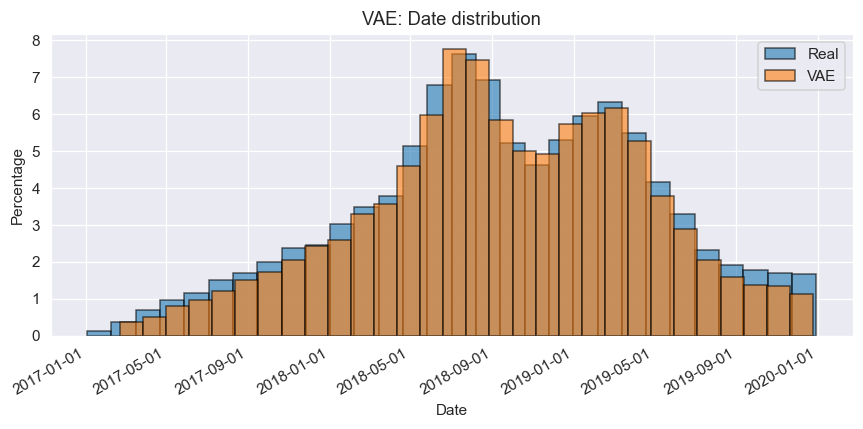

In [463]:
pairs = {
    "GAN": airline_gan_dataset,
    "VAE": airline_vae_dataset,
}

for method, synth_df in pairs.items():
    # prepare both dataframes
    dfs = {"Real": airline_dataset.copy(), method: synth_df.copy()}
    for name, df in dfs.items():
        df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
        dfs[name] = df

    fig, ax = plt.subplots(figsize=(8, 4))
    for name, df in dfs.items():
        dates = df["Date"].dropna()
        # convert to matplotlib float dates
        x = mdates.date2num(dates)
        # weights so that the sum of bar heights = 100%
        weights = np.ones_like(x) / len(x) * 100
        ax.hist(x, bins=30, weights=weights, alpha=0.6, label=name, edgecolor="black")

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate(rotation=30)
    ax.set_title(f"{method}: Date distribution")
    ax.set_xlabel("Date")
    ax.set_ylabel("Percentage")
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Correlation matrixes

##### Utility methods for correlation matrixes (Pearson, eta correlation ratio, Cramer's V)

In [464]:
def correlation_num_to_num_matrix_plot(df1, df2, columns, title_prefix=""):
    """
    Plots numeric-numeric correlations for Real vs Synthetic and their absolute difference.
    """
    corr_orig = df1[columns].corr()
    corr_gan = df2[columns].corr()
    diff_gan = (corr_orig - corr_gan).abs()

    # 2) Original heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_orig, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title("Numeric-Numeric Correlation — Original")
    plt.tight_layout()
    plt.show()

    # 3) GAN heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_gan, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title(f"Numeric-Numeric Correlation — {title_prefix}")
    plt.tight_layout()
    plt.show()

    # 4) Absolute-difference heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(diff_gan, vmin=0, vmax=1, cmap="rocket_r", annot=False, fmt=".2f")
    plt.title(f"Absolute Difference |Original – {title_prefix}|")
    plt.tight_layout()
    plt.show()


def correlation_ratio(categories, values):
    df = values.to_frame(name="x").join(categories.rename("g"))
    df = df.dropna(subset=["x", "g"])
    grand_mean = df["x"].mean()
    ss_between = sum(
        grp["x"].count() * (grp["x"].mean() - grand_mean) ** 2
        for _, grp in df.groupby("g")
    )
    ss_total = ((df["x"] - grand_mean) ** 2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan


def correlation_cat_num_matrix_plot(
    df_real, df_syn, num_cols, cat_cols, title_prefix="", squared=False
):
    def _eta(col_cat, col_num):
        overall = col_num.mean()
        stats = col_num.groupby(col_cat, dropna=False).agg(["count", "mean"])
        ss_between = (stats["count"] * (stats["mean"] - overall) ** 2).sum()
        ss_total = ((col_num - overall) ** 2).sum()
        val = ss_between / ss_total if ss_total > 0 else np.nan
        return val if squared else np.sqrt(val)

    eta_real = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)
    eta_syn = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)

    for c in cat_cols:
        for n in num_cols:
            eta_real.loc[c, n] = _eta(df_real[c], df_real[n])
            eta_syn.loc[c, n] = _eta(df_syn[c], df_syn[n])

    eta_diff = (eta_real - eta_syn).abs()

    for mat, ttl in zip(
        [eta_real, eta_syn, eta_diff],
        [
            "n Real" if not squared else "n2 Real",
            "n Synthetic" if not squared else "n2 Synthetic",
            "Abs diff",
        ],
    ):
        fig, ax = plt.subplots(figsize=(1.5 * len(num_cols), 0.5 * len(cat_cols) + 3))
        sns.heatmap(
            mat,
            mask=mat.isna(),
            annot=True,
            fmt=".2f",
            xticklabels=num_cols,
            yticklabels=cat_cols,
            cmap="rocket_r",
            vmin=0,
            vmax=1,
            cbar_kws={"label": "η" if not squared else "η²"},
            ax=ax,
        )
        ax.set_title(f"{ttl} ({title_prefix})")
        plt.tight_layout()
        plt.show()


def cramers_v(contingency: np.ndarray, bias_correction: bool = True) -> float:
    """
    Compute Cramer's V statistic for an r-c contingency table.
    If bias_correction=True applies the correction of Bergsma
    """
    chi2, _, _, _ = chi2_contingency(contingency, correction=False)
    n = contingency.sum()
    phi2 = chi2 / n

    r, k = contingency.shape
    # optional bias correction
    if bias_correction:
        phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        r_corr = r - ((r - 1) ** 2) / (n - 1)
        k_corr = k - ((k - 1) ** 2) / (n - 1)
        return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
    else:
        return np.sqrt(phi2 / (min(r - 1, k - 1)))


def correlation_cat_cat_matrix_plot(
    df_real: pd.DataFrame,
    df_syn: pd.DataFrame,
    cat_cols: list[str],
    title_prefix: str = "",
    bias_correction: bool = True,
):
    """
    Plots categorical-categorical association (Cramers V) matrices for
    real vs synthetic data and their absolute difference.
    """
    # prepare empty DataFrames
    V_real = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    V_syn = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for i, ci in enumerate(cat_cols):
        for j, cj in enumerate(cat_cols):
            # cross‐tabulate and compute Cramer's V
            cont_real = pd.crosstab(df_real[ci], df_real[cj]).values
            cont_syn = pd.crosstab(df_syn[ci], df_syn[cj]).values

            V_real.iloc[i, j] = cramers_v(cont_real, bias_correction)
            V_syn.iloc[i, j] = cramers_v(cont_syn, bias_correction)

    V_diff = (V_real - V_syn).abs()

    # Plotting helper
    def _plot_heatmap(mat, title, cmap="rocket_r", vmin=0, vmax=1):
        plt.figure(figsize=(1.2 * len(cat_cols), 1.2 * len(cat_cols)))
        sns.heatmap(
            mat,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            xticklabels=cat_cols,
            yticklabels=cat_cols,
            square=True,
            cbar_kws={"label": "Cramers V"},
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()

    _plot_heatmap(V_real, f"Cramers V — Original")
    _plot_heatmap(V_syn, f"Cramers V — {title_prefix or 'Synthetic'}")
    _plot_heatmap(
        V_diff,
        f"Abs Diff |Original − {title_prefix or 'Synthetic'}|",
        cmap="vlag",
        vmin=0,
        vmax=V_diff.max().max(),
    )

##### Correlation matrixes - numeric to numeric (Pearson)

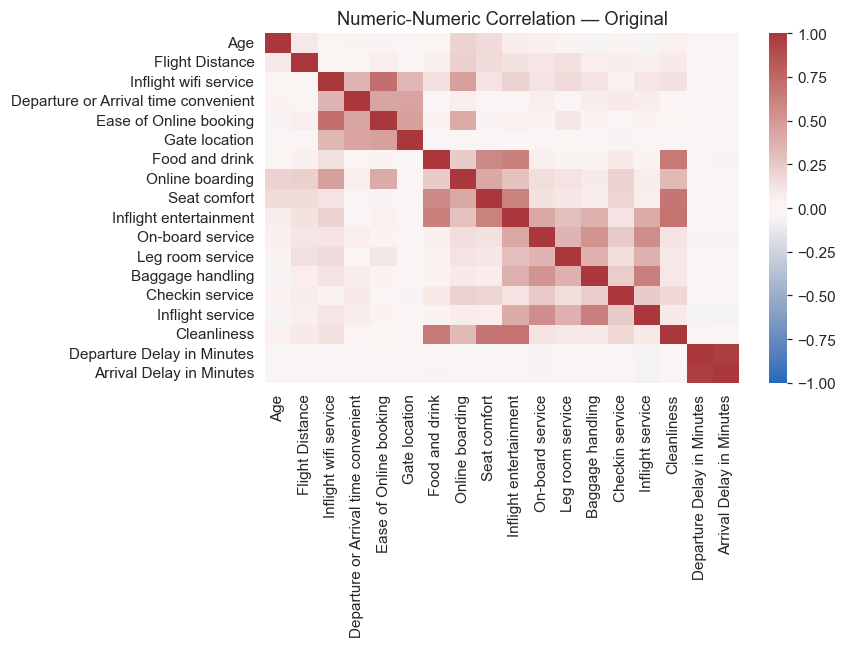

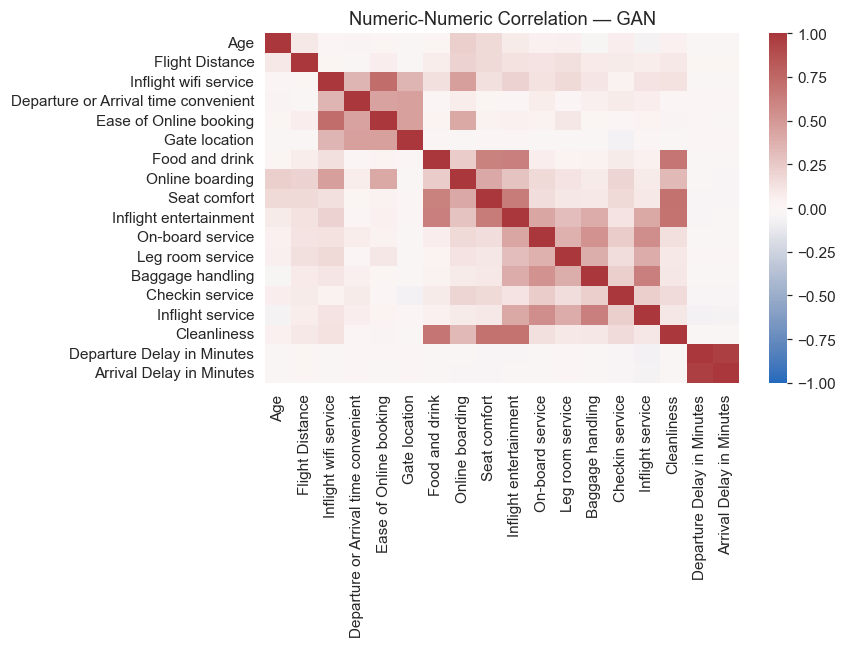

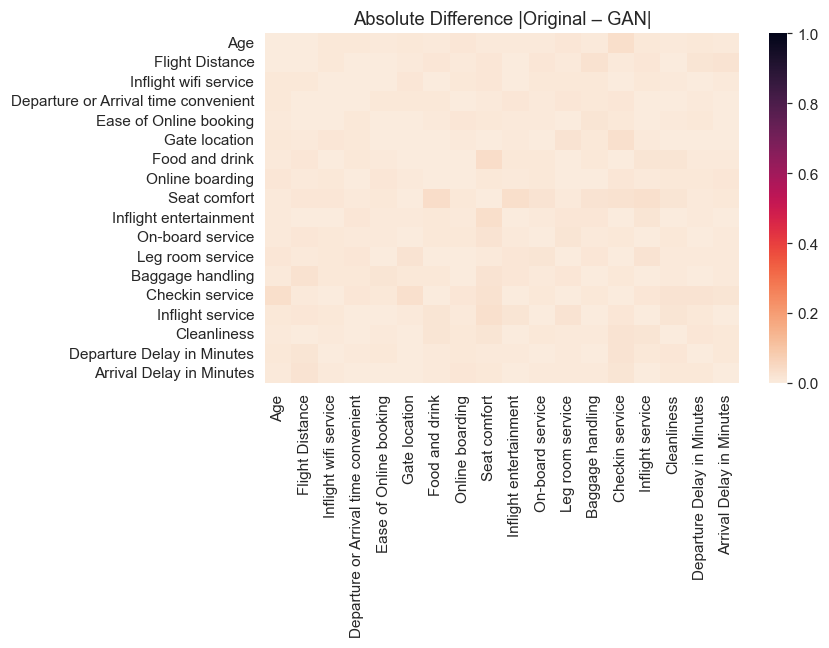

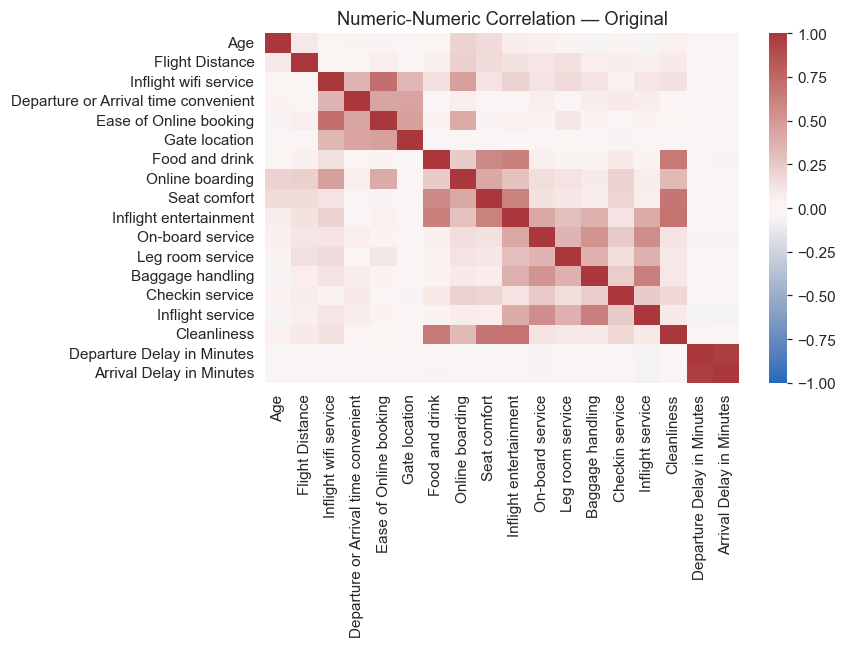

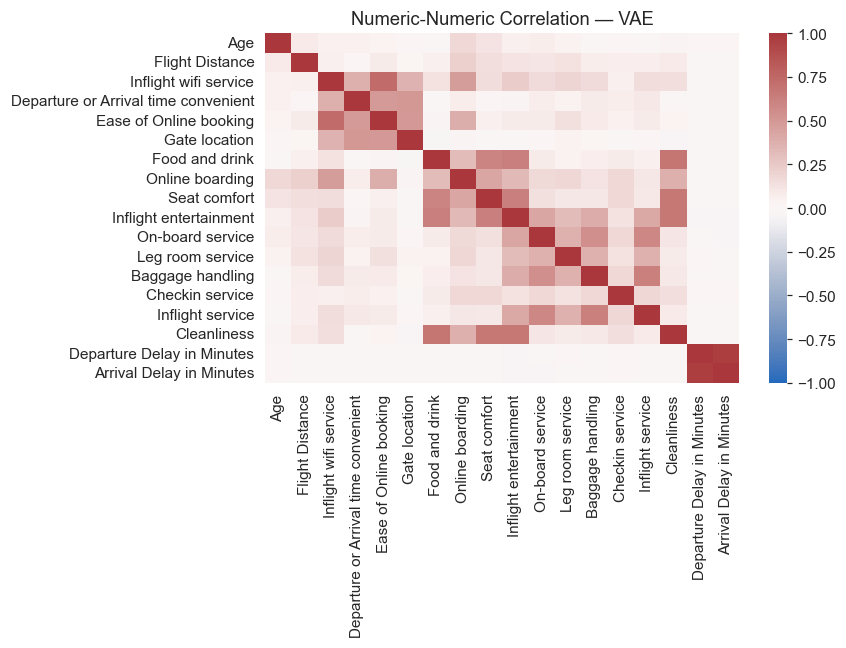

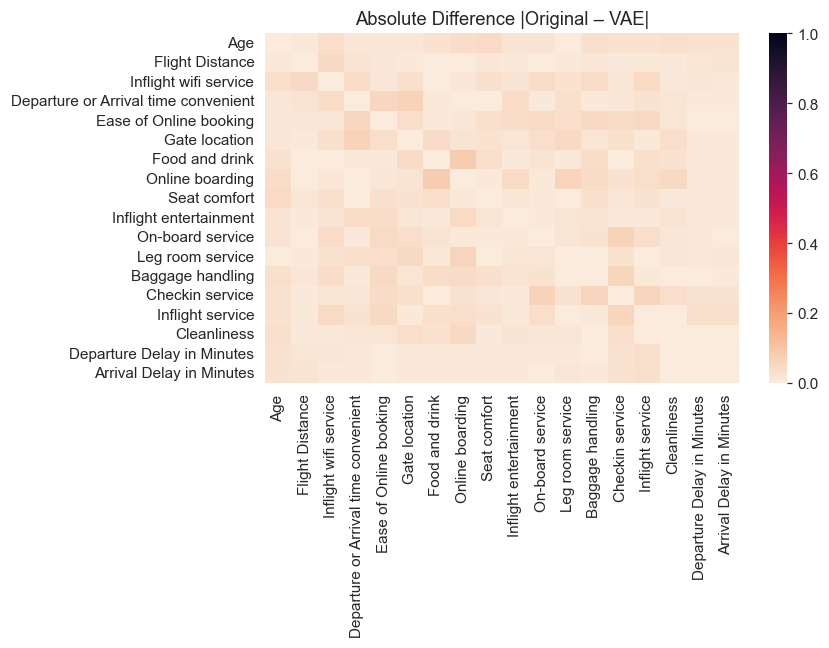

In [465]:
correlation_num_to_num_matrix_plot(
    airline_dataset, airline_gan_dataset, airline_num_cols, "GAN"
)
correlation_num_to_num_matrix_plot(
    airline_dataset, airline_vae_dataset, airline_num_cols, "VAE"
)

##### Correlation matrixes - categoric to numeric (eta)

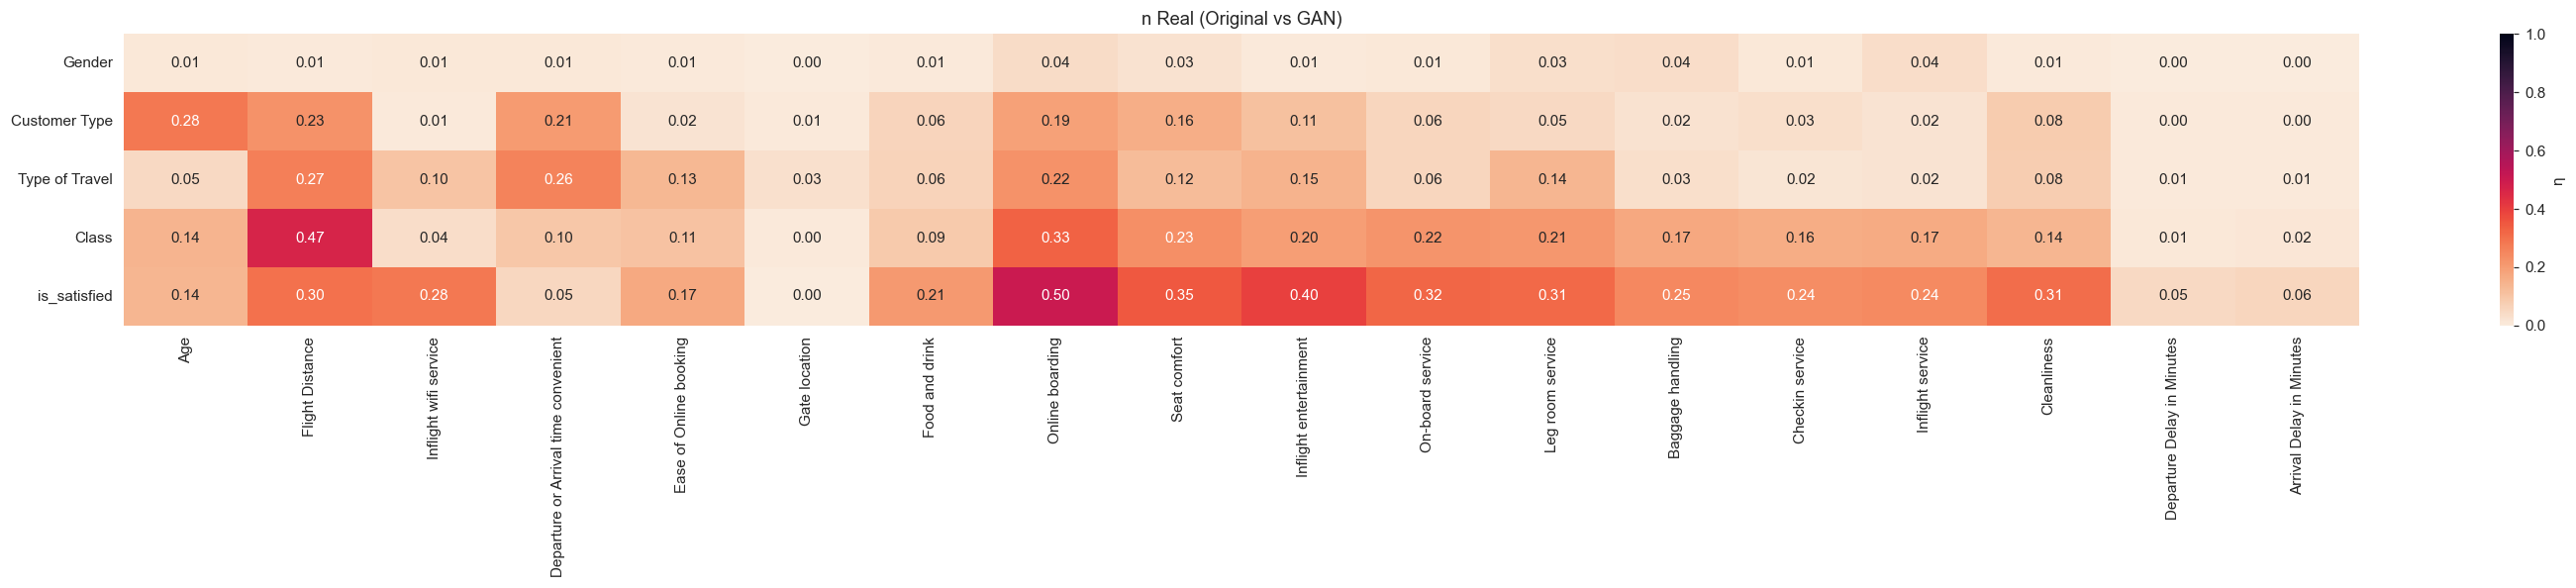

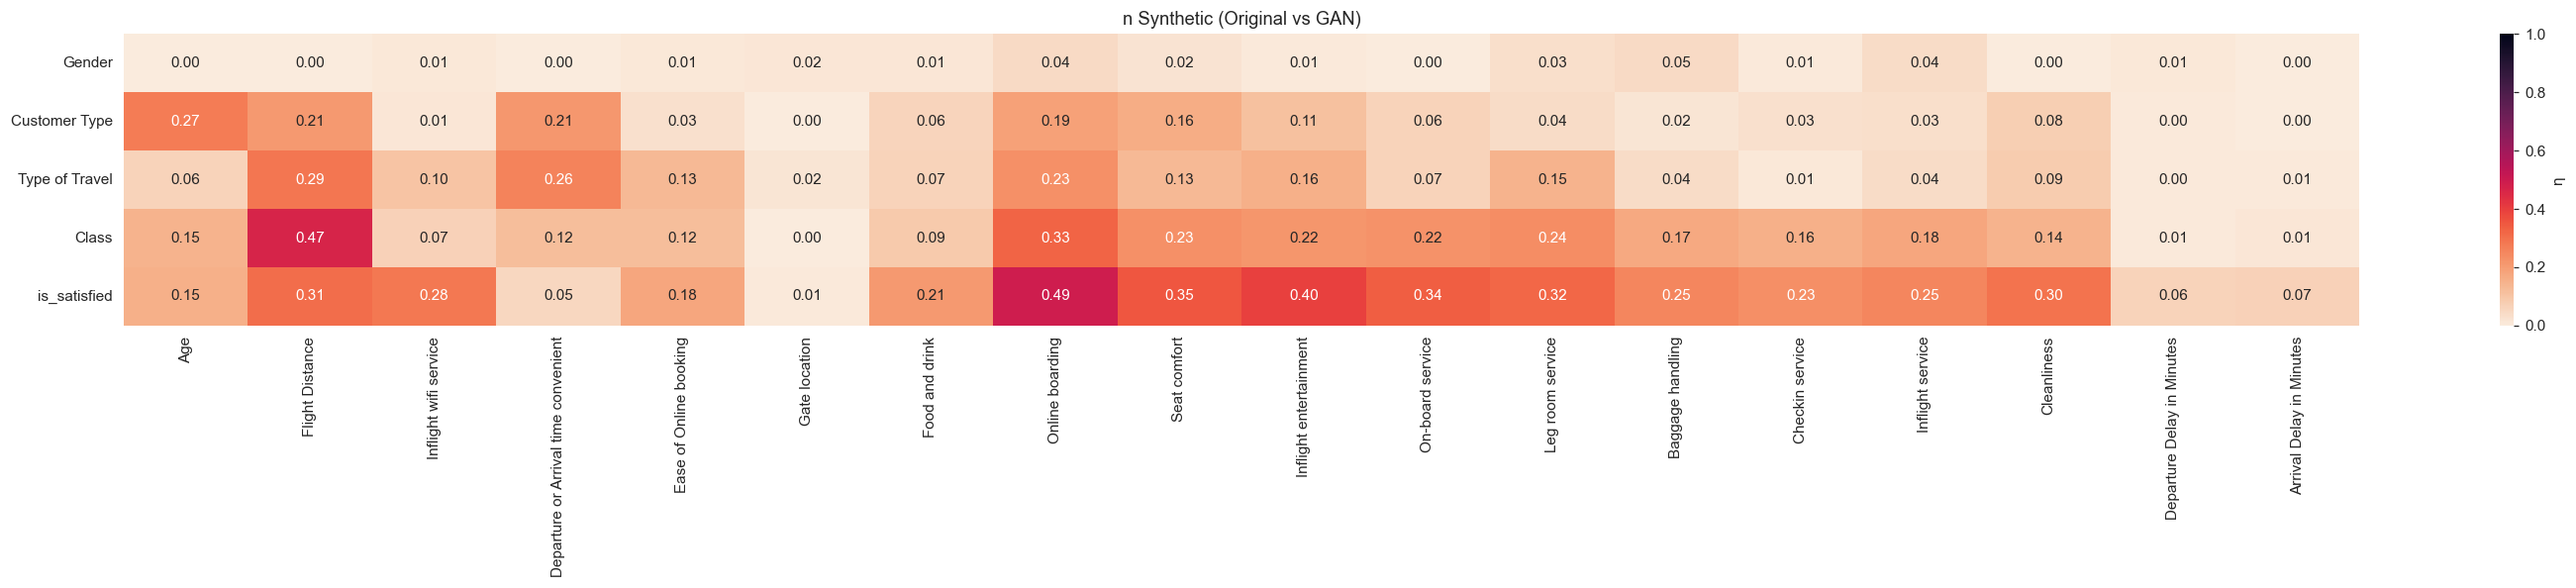

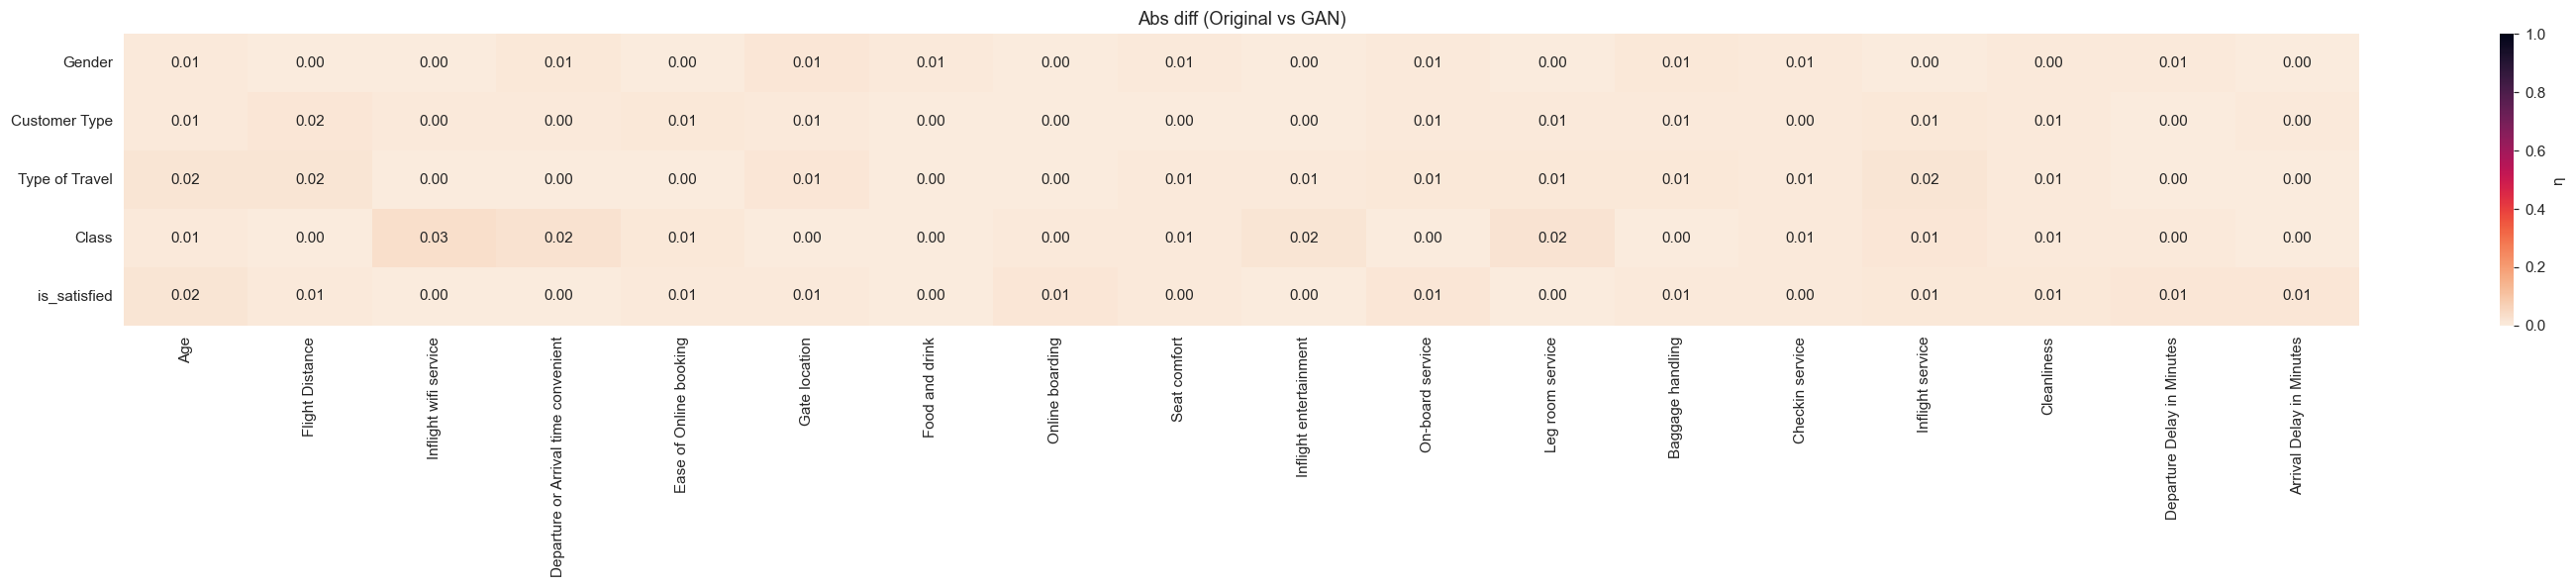

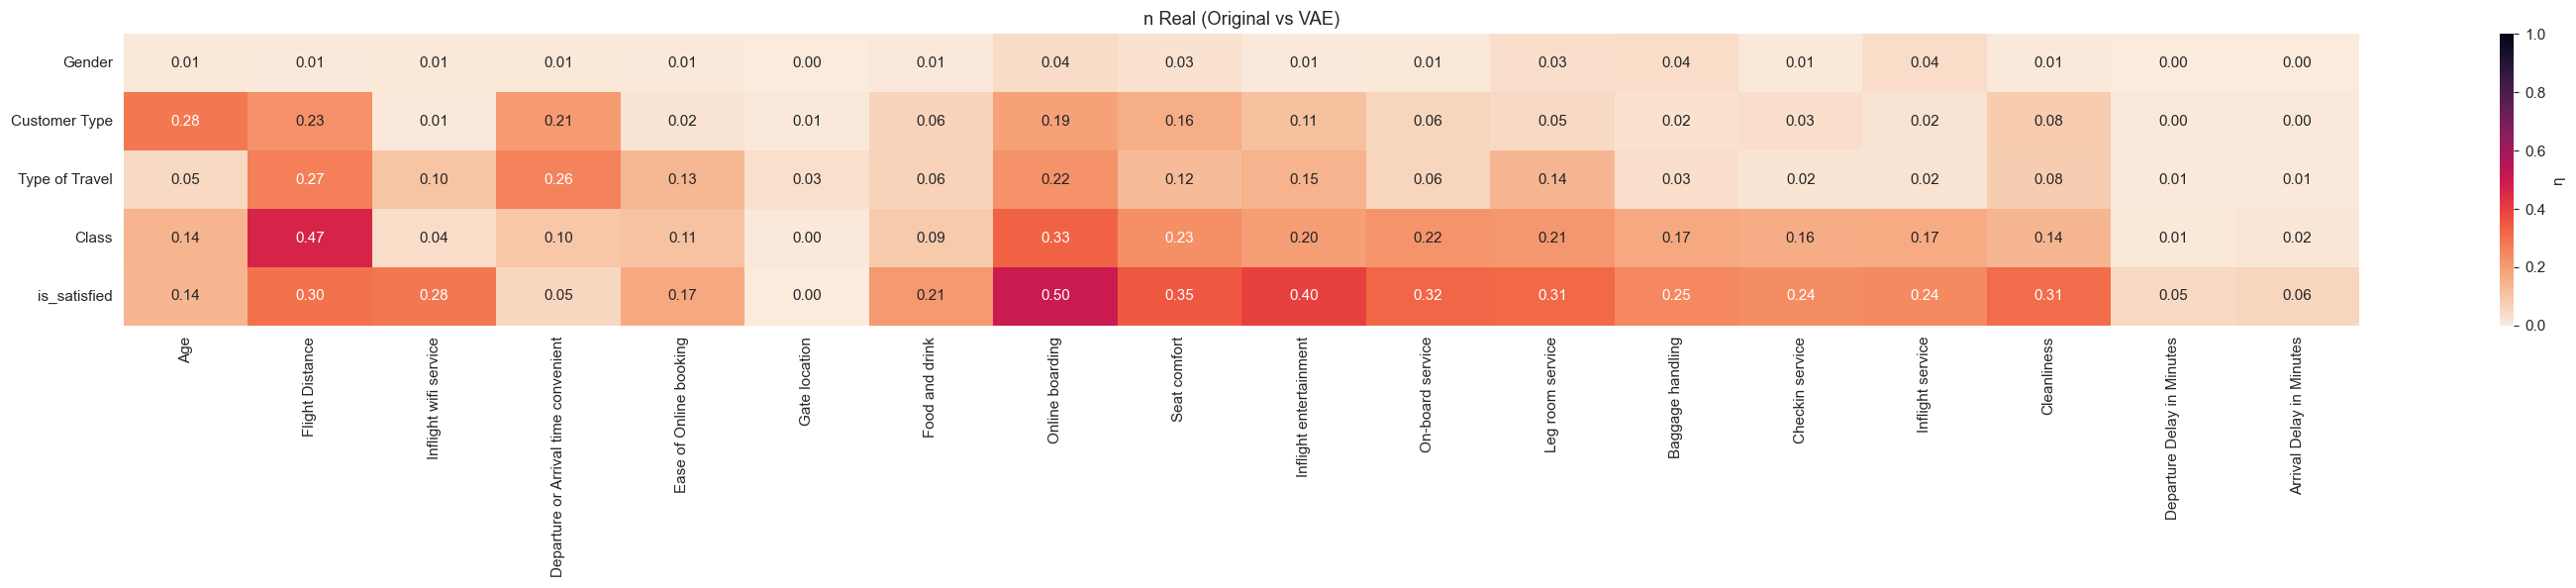

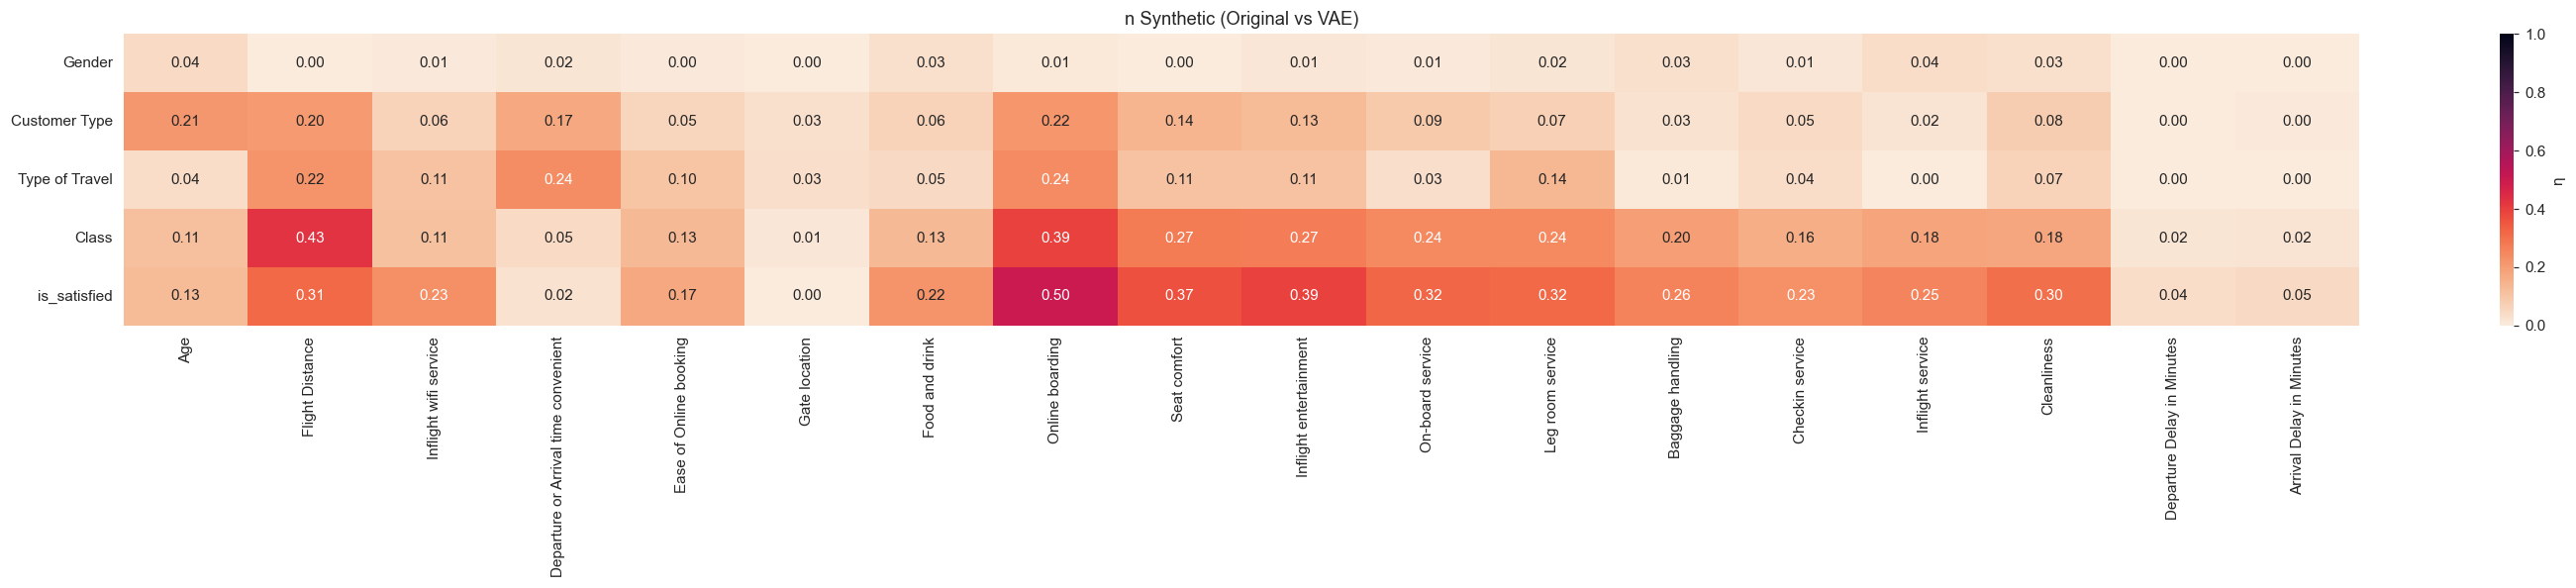

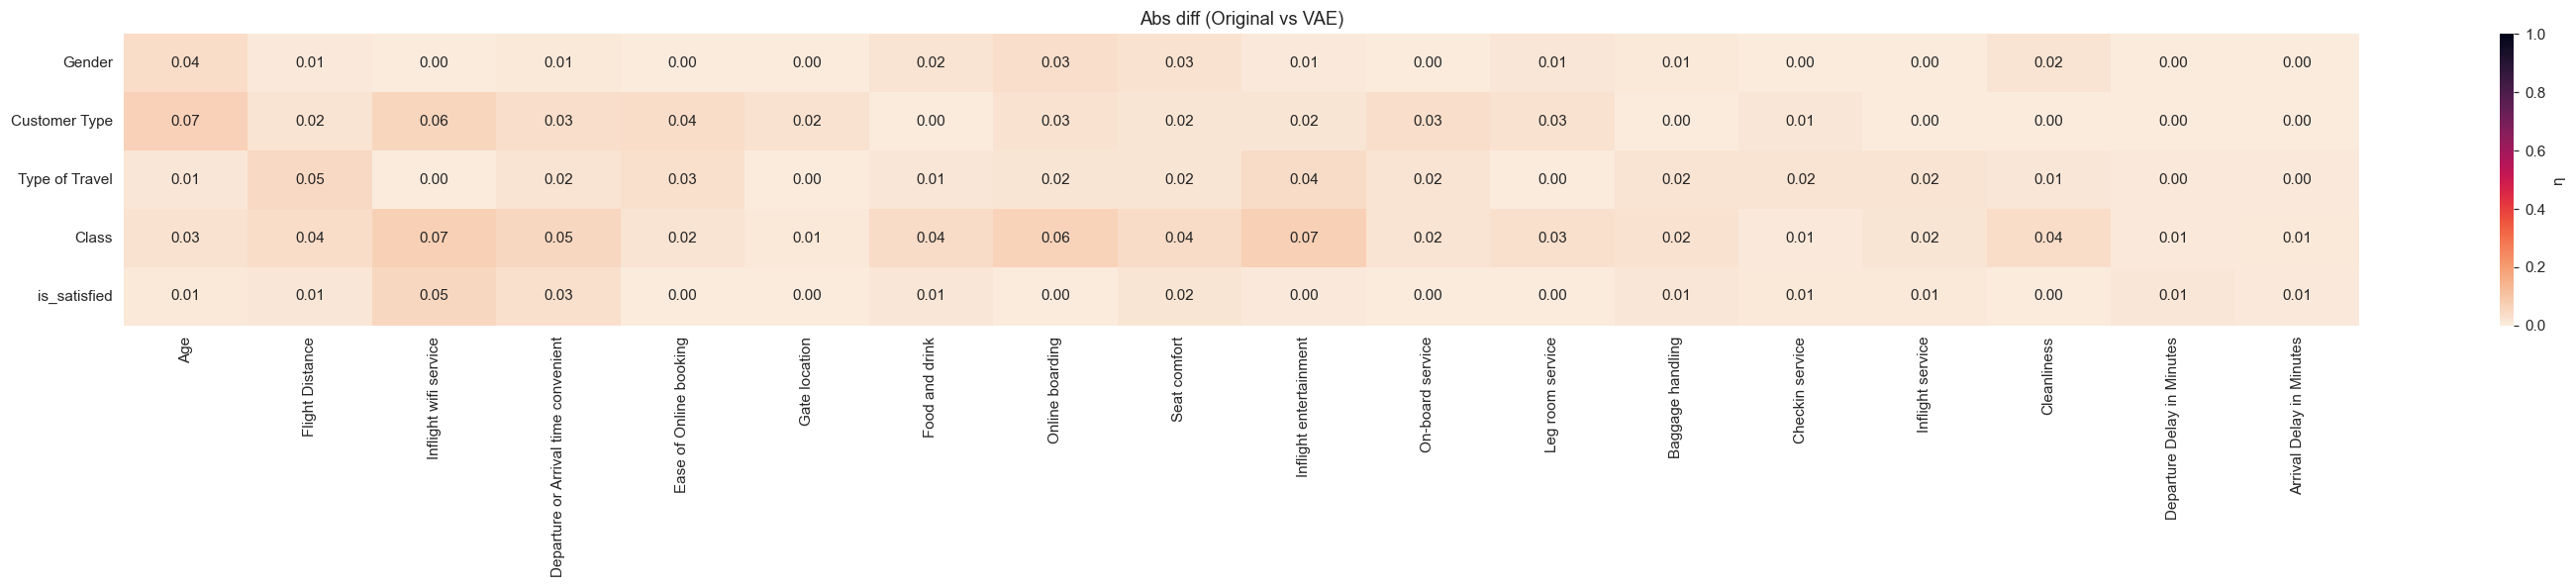

In [466]:
correlation_cat_num_matrix_plot(
    airline_dataset,
    airline_gan_dataset,
    airline_num_cols,
    airline_cat_cols,
    "Original vs GAN",
)
correlation_cat_num_matrix_plot(
    airline_dataset,
    airline_vae_dataset,
    airline_num_cols,
    airline_cat_cols,
    "Original vs VAE",
)

##### Correlation matrixes - categorical to categorical (Cramer's V)

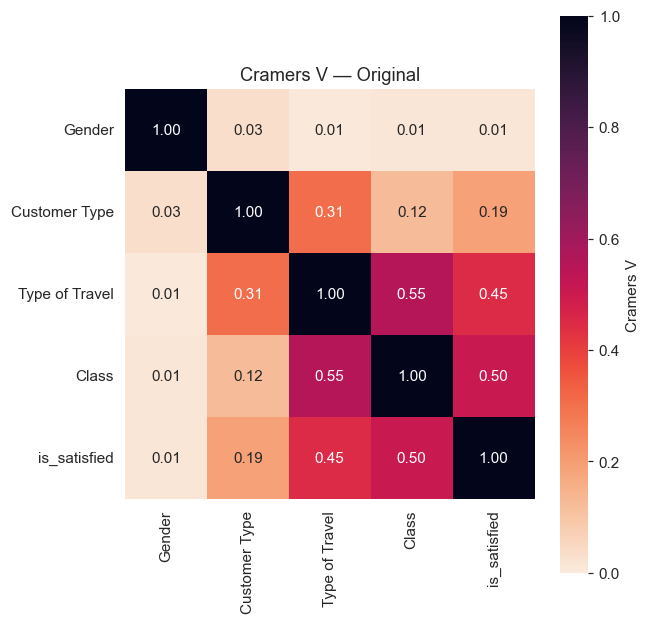

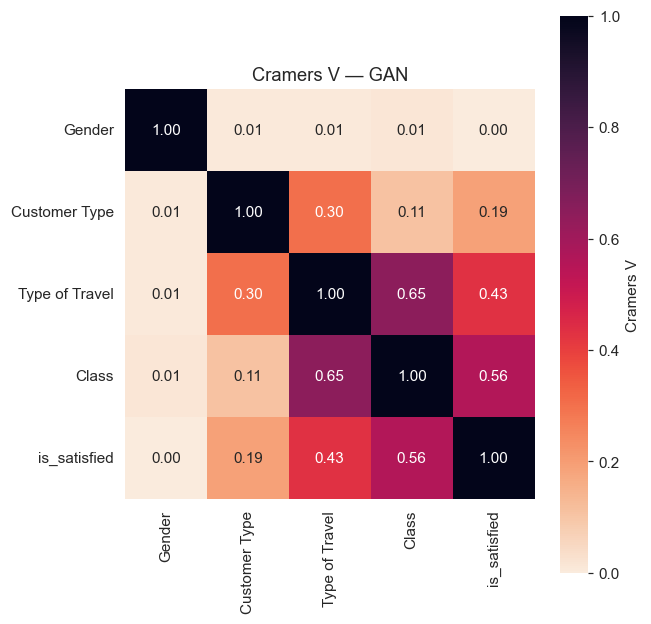

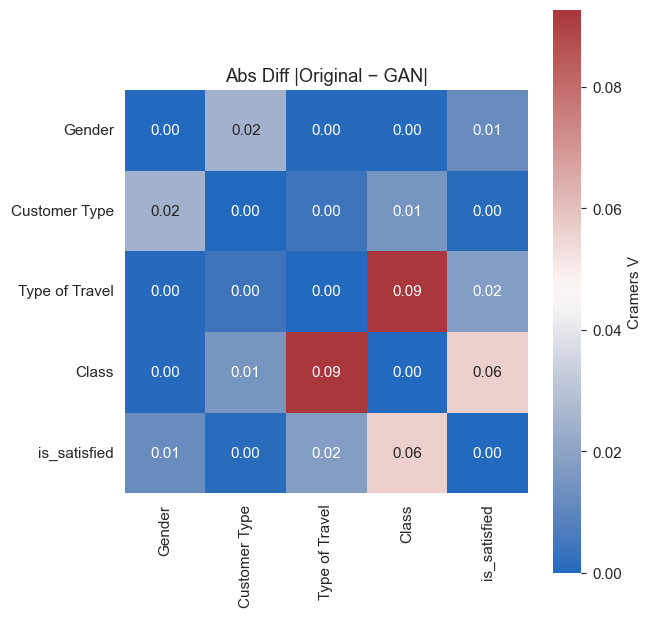

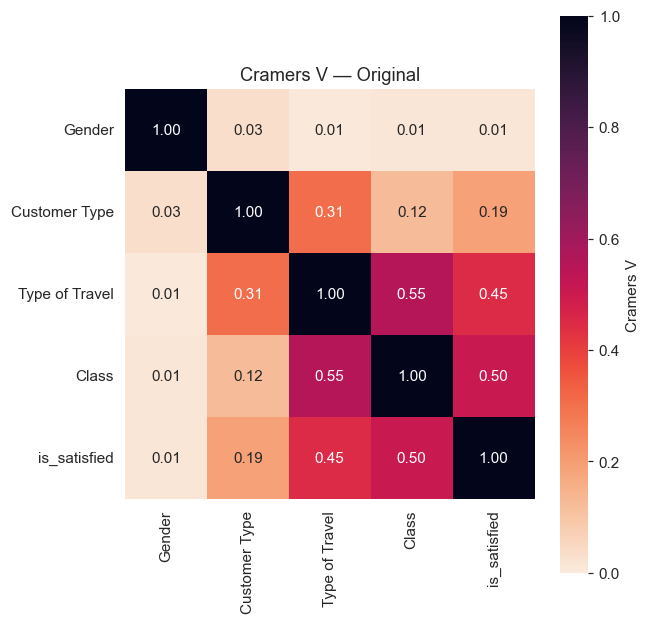

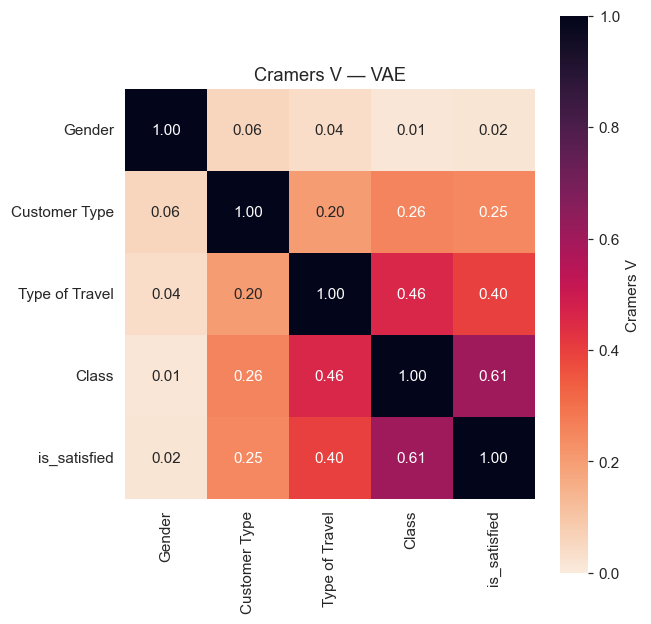

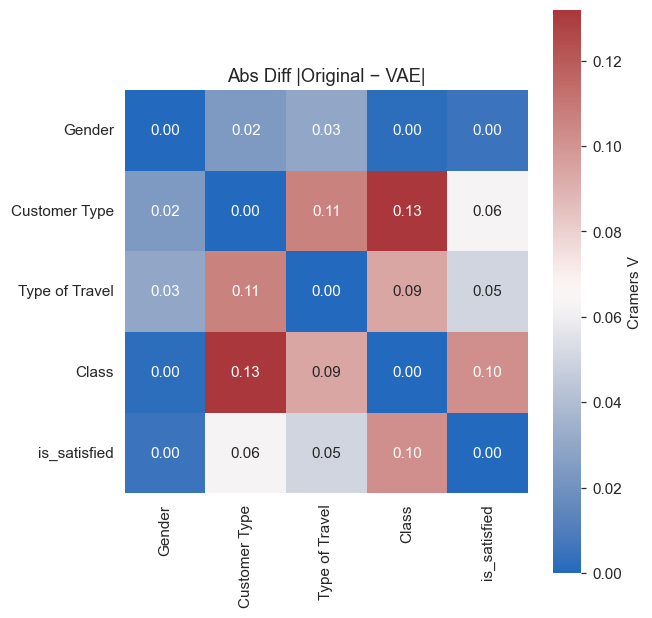

In [467]:
correlation_cat_cat_matrix_plot(
    airline_dataset, airline_gan_dataset, airline_cat_cols, "GAN"
)
correlation_cat_cat_matrix_plot(
    airline_dataset, airline_vae_dataset, airline_cat_cols, "VAE"
)

#### t-SNE plot

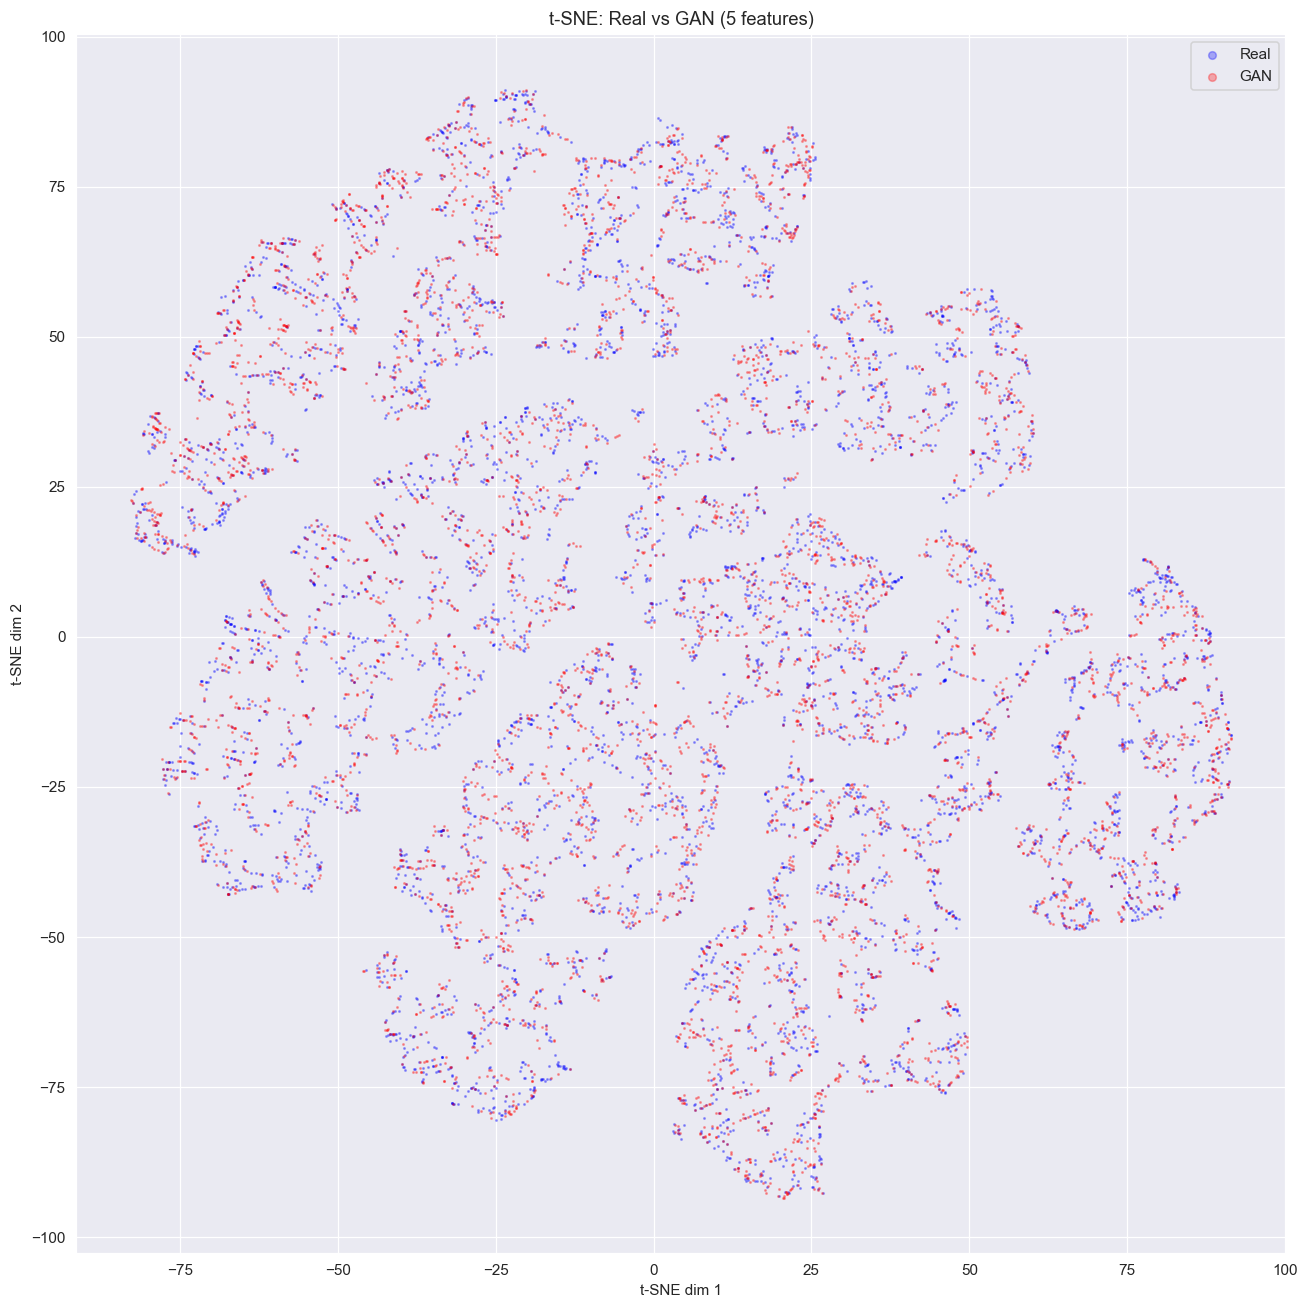

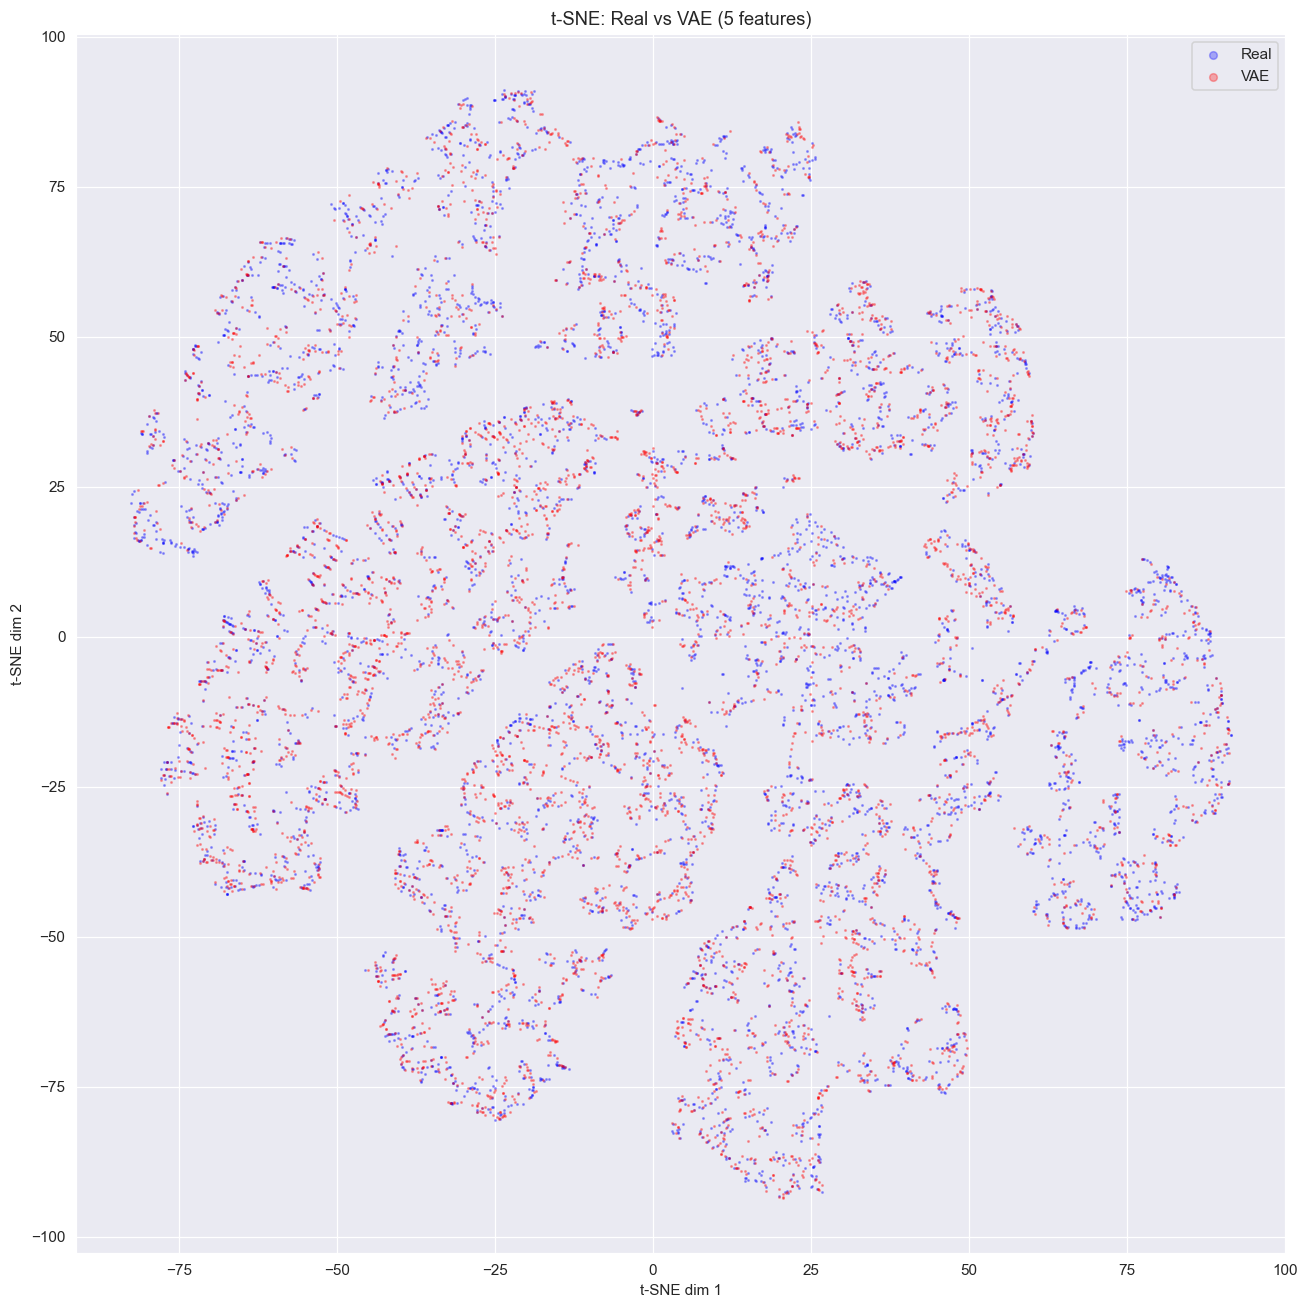

In [468]:
# Select 5 key numeric columns
cols = [
    "Age",
    "Arrival Delay in Minutes",
    "Departure Delay in Minutes",
    "Flight Distance",
    "Inflight entertainment",
]

# Sample for speed
SAMPLE_N = 6000
real5 = airline_dataset[cols].dropna().sample(SAMPLE_N, random_state=0)
gan5 = airline_gan_dataset[cols].dropna().sample(SAMPLE_N, random_state=0)
vae5 = airline_vae_dataset[cols].dropna().sample(SAMPLE_N, random_state=0)

# Standardize based on real data
scaler = StandardScaler().fit(real5)
real_scaled = scaler.transform(real5)
gan_scaled = scaler.transform(gan5)
vae_scaled = scaler.transform(vae5)

# Run t-SNE on all data together for a shared embedding
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
Z_combined = tsne.fit_transform(np.vstack([real_scaled, gan_scaled, vae_scaled]))

# Split back into separate sets
Z_real = Z_combined[:SAMPLE_N]
Z_gan = Z_combined[SAMPLE_N : 2 * SAMPLE_N]
Z_vae = Z_combined[2 * SAMPLE_N : 3 * SAMPLE_N]

# Plot Real vs GAN
plt.figure(figsize=(12, 12))
plt.scatter(Z_real[:, 0], Z_real[:, 1], s=1, alpha=0.3, label="Real", color="blue")
plt.scatter(Z_gan[:, 0], Z_gan[:, 1], s=1, alpha=0.3, label="GAN", color="red")
plt.title("t-SNE: Real vs GAN (5 features)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=5)
plt.tight_layout()
plt.show()

# Plot Real vs VAE
plt.figure(figsize=(12, 12))
plt.scatter(Z_real[:, 0], Z_real[:, 1], s=1, alpha=0.3, label="Real", color="blue")
plt.scatter(Z_vae[:, 0], Z_vae[:, 1], s=1, alpha=0.3, label="VAE", color="red")
plt.title("t-SNE: Real vs VAE (5 features)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=5)
plt.tight_layout()
plt.show()

### Discriminator of synthetic data vs original

#### Utility classes/methods for discriminator model

In [469]:
def logistic_discriminator(
    real_df, synth_df, num_cols, cat_cols, n_components=10, random_state=42
):
    # label and split
    real = real_df.copy()
    real["__label"] = 0
    synth = synth_df.copy()
    synth["__label"] = 1
    df = pd.concat([real, synth], ignore_index=True)
    X = df[num_cols + cat_cols]
    y = df["__label"]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=random_state
    )

    # Preprocessing: impute - scale numerics, impute - OHE categoricals
    num_pipe = Pipeline(
        [("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
    )
    cat_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="constant", fill_value="__miss__")),
            (
                "ohe",
                OneHotEncoder(
                    drop="first", handle_unknown="ignore", sparse_output=False
                ),
            ),
        ]
    )
    prep = ColumnTransformer(
        [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], remainder="drop"
    )

    # Full pipeline: prep - PCA - logistic
    pipe = Pipeline(
        [
            ("prep", prep),
            ("pca", PCA(n_components=n_components, random_state=random_state)),
            (
                "clf",
                LogisticRegression(
                    C=0.1,
                    class_weight="balanced",
                    max_iter=500,
                    random_state=random_state,
                ),
            ),
        ]
    )

    # Fit and evaluate
    pipe.fit(X_tr, y_tr)
    probs = pipe.predict_proba(X_te)[:, 1]
    preds = pipe.predict(X_te)

    metrics = {
        "Accuracy": accuracy_score(y_te, preds),
        "ROC AUC": roc_auc_score(y_te, probs),
    }
    fpr, tpr, _ = roc_curve(y_te, probs)
    cm = confusion_matrix(y_te, preds)

    return metrics, (fpr, tpr), cm

#### Run disriminator on both synthetic datasets and compare results

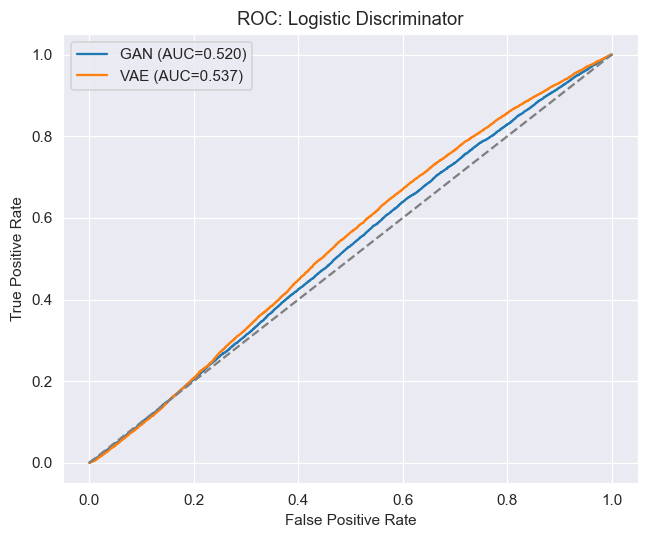

In [470]:
target_col = "is_satisfied"
cat_cols = [c for c in airline_cat_cols if c != target_col]


results, roc_data, cm_data = {}, {}, {}
for name, synth in [("GAN", airline_gan_dataset), ("VAE", airline_vae_dataset)]:
    m, (fpr, tpr), cm = logistic_discriminator(
        real_df=airline_dataset,
        synth_df=synth,
        num_cols=airline_num_cols,
        cat_cols=cat_cols,
        n_components=10,
        random_state=42,
    )
    results[name] = m
    roc_data[name] = (fpr, tpr)
    cm_data[name] = cm

# Display metrics
metrics_df = pd.DataFrame(results).T
display(
    metrics_df.style.format("{:.3f}").set_caption(
        "Logistic Discriminator: Real vs GAN/VAE"
    )
)

# Plot ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for name in roc_data:
    fpr, tpr = roc_data[name]
    ax.plot(fpr, tpr, label=f"{name} (AUC={results[name]['ROC AUC']:.3f})")
ax.plot([0, 1], [0, 1], "--", color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC: Logistic Discriminator")
ax.legend()
plt.tight_layout()
plt.show()

ROC AUC (Receiver Operating Characteristic – Area Under Curve)

### Classification if user satisfied with airline services

#### Utility method for augment minority, evaluate

In [471]:
def evaluate(train_X, train_y, test_X, test_y) -> dict[str, float]:
    X_tr = ct.transform(train_X)
    X_te = ct.transform(test_X)
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features=0.3,
        min_samples_leaf=1,
        random_state=42,
    )
    clf.fit(X_tr, train_y)
    preds = clf.predict(X_te)
    probs = clf.predict_proba(X_te)[:, 1]
    return {
        "ROC AUC": roc_auc_score(test_y, probs) * 100,
        "F1 score": f1_score(test_y, preds) * 100,
    }

In [472]:
target_col = "is_satisfied"
cat_cols = [c for c in airline_cat_cols if c != target_col]
# Get feature columns(numeric + categoric + boolean, except target)
feature_cols = [
    c
    for c in airline_dataset.columns
    if c in airline_num_cols + airline_cat_cols and c != target_col
]
# Ensure target column is int type
for df in (airline_dataset, airline_gan_dataset, airline_vae_dataset):
    df[target_col] = df[target_col].astype(int)
# Split data to train and test parts
X = airline_dataset[feature_cols]
y = airline_dataset[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# define & fit ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), airline_num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)
ct.fit(X_train)

# Run evaluations
results = evaluate(X_train, y_train, X_test, y_test)
results["Real + GAN"] = evaluate(
    pd.concat([X_train, airline_gan_dataset[feature_cols]], ignore_index=True),
    pd.concat([y_train, airline_gan_dataset[target_col]], ignore_index=True),
    X_test,
    y_test,
)
results["Real + VAE"] = evaluate(
    pd.concat([X_train, airline_vae_dataset[feature_cols]], ignore_index=True),
    pd.concat([y_train, airline_vae_dataset[target_col]], ignore_index=True),
    X_test,
    y_test,
)

df = pd.DataFrame(results).T
baseline = df.iloc[0]

for metric in df.columns:
    df[f"{metric} % change"] = (df[metric] - baseline[metric]) / baseline[metric] * 100

display(df)

ROC AUC   F1 score  ROC AUC % change  F1 score % change
Real only   98.184239  94.184264          0.000000           0.000000
Real + GAN  99.251042  95.199668          1.086532           1.078104
Real + VAE  99.251221  95.103628          1.086714           0.976133

ROC AUC - true positive percentage (how many rows identified as 'satisfied' right)

F1 score - metric of precision - how well discriminator balances avoiding false positives and false negatives

# Household Power Consumption Dataset

## Preprocessing and data generation

##### Metadata for synthetic generation

In [3]:
household_dataset_metadata = {
    "Date_time": FieldMetadata(
        data_type=DataType.DATETIME, datetime_format="%Y-%m-%d %H:%M:%S"
    ),
    "Global_active_power": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    "Global_reactive_power": FieldMetadata(
        data_type=DataType.DECIMAL, decimal_places=3
    ),
    "Voltage": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=2),
    "Global_intensity": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_1": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_2": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_3": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
}

In [4]:
household_dataset_num_cols = [
    key
    for key, value in household_dataset_metadata.items()
    if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
]

##### Loading and preprocessing a dataset for training neural networks

In [5]:
def load_household_dataset(csv_path: str):
    # Loading dataset
    raw = pd.read_csv(csv_path, sep=";", dayfirst=True, na_values="?")
    # Parse datetime explicitly to avoid FutureWarning
    raw["Date_time"] = pd.to_datetime(
        raw["Date"].str.strip() + " " + raw["Time"].str.strip(),
        format="%d/%m/%Y %H:%M:%S",
        dayfirst=True,
        errors="coerce",
    )
    # Drop rows where parsing failed
    df_power = raw.dropna(subset=["Date_time"]).drop(columns=["Date", "Time"])

    df_power = df_power.set_index("Date_time").sort_index()
    # Resample to an explicit hourly index
    df_hourly = df_power.resample("h").sum()
    # Interpolate missing hours by time
    df_hourly_interp = df_hourly.interpolate(method="time")
    # interpolate numeric columns
    df_hourly_interp[household_dataset_num_cols] = df_hourly[
        household_dataset_num_cols
    ].interpolate(method="time")
    # form final dataset for training
    return df_hourly_interp.reset_index()


household_dataset = load_household_dataset("datasets/household_power_consumption.csv")
print(f"Rows count in dataset: {household_dataset.shape[0]}")
print(f"Column amount: {household_dataset.shape[1]}")
display(household_dataset.head())

Rows count in dataset: 34589
Column amount: 8


Date_time  Global_active_power  Global_reactive_power   Voltage  \
0 2006-12-16 17:00:00              152.024                  8.244   8447.18   
1 2006-12-16 18:00:00              217.932                  4.802  14074.81   
2 2006-12-16 19:00:00              204.014                  5.114  13993.95   
3 2006-12-16 20:00:00              196.114                  4.506  14044.29   
4 2006-12-16 21:00:00              183.388                  4.600  14229.52   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             651.6             0.0            19.0           607.0  
1             936.0             0.0           403.0          1012.0  
2             870.2             0.0            86.0          1001.0  
3             835.0             0.0             0.0          1007.0  
4             782.8             0.0            25.0          1033.0

##### Data generation using GAN and VAE neural networks

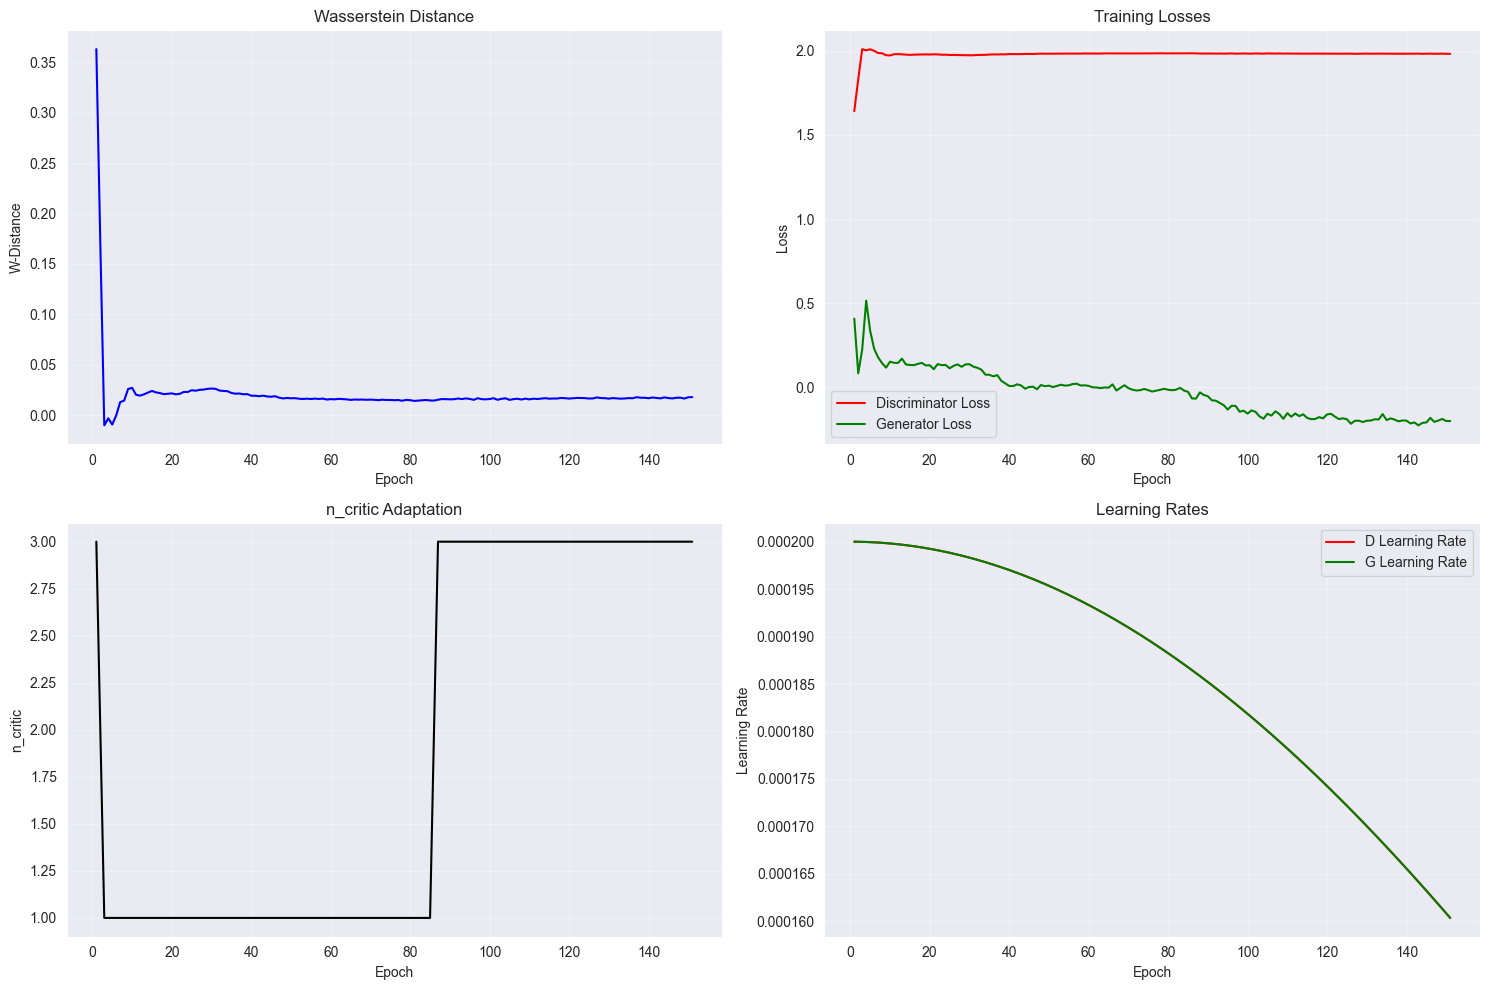

Training completed in 364.02 seconds


In [6]:
start_time = time.time()
cfg = GanConfig(
    training=GanTrainingConfig(epochs=500, verbose=True),
    optimizer=GanOptimizerConfig(
        g_lr=2e-4,
        d_lr=2e-4,
    ),
    scheduler=SchedulerConfig(
        patience=150,
    ),
    loss=GanLossConfig(
        regularization=GanRegularizationConfig(
            use_hinge=True, use_bias_correction=True
        ),
        feature_matching=GanFeatureMatchingConfig(use_fm_loss=True, fm_w=10.0),
        covariance=GanCovarianceConfig(use_cov_loss=True, cov_w=2.0),
        delta=GanDeltaConfig(use_delta_loss=True, delta_w=5.0),
    ),
)
gan_full = GAN(household_dataset, household_dataset_metadata, cfg)
gan_full.fit()
S_gan_full = gan_full.generate(len(household_dataset), temperature=0.7)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

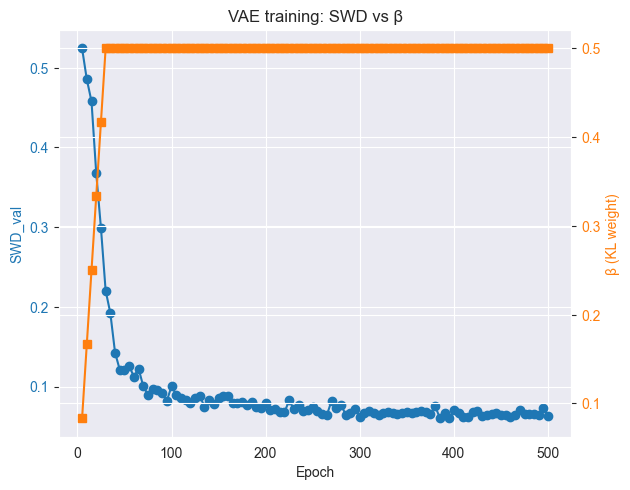

In [7]:
vae_full = VAE(
    household_dataset,
    household_dataset_metadata,
    VaeConfig(training=VaeTrainingConfig(epochs=600, verbose=True)),
)
vae_full.fit()
S_vae_full = vae_full.generate(len(household_dataset))

##### Statistical analysis of synthetic data

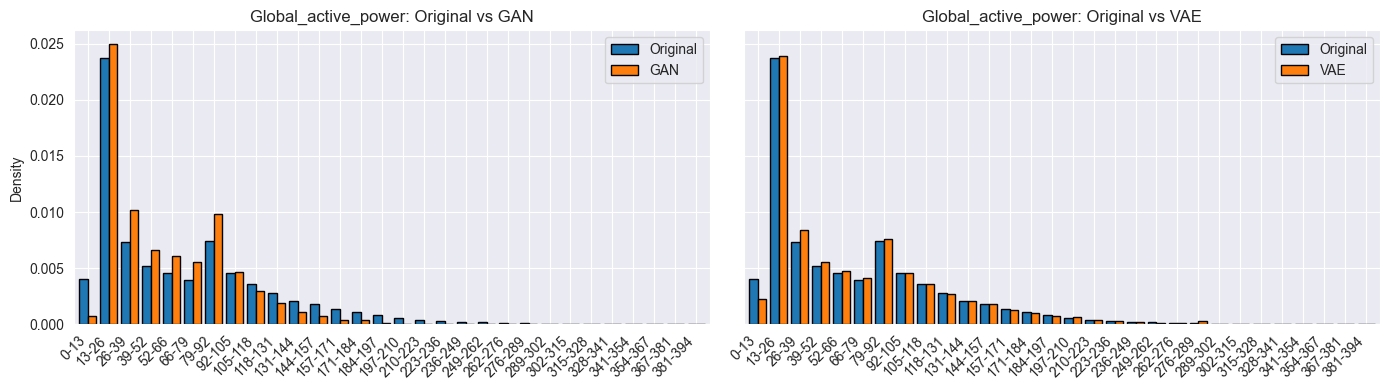

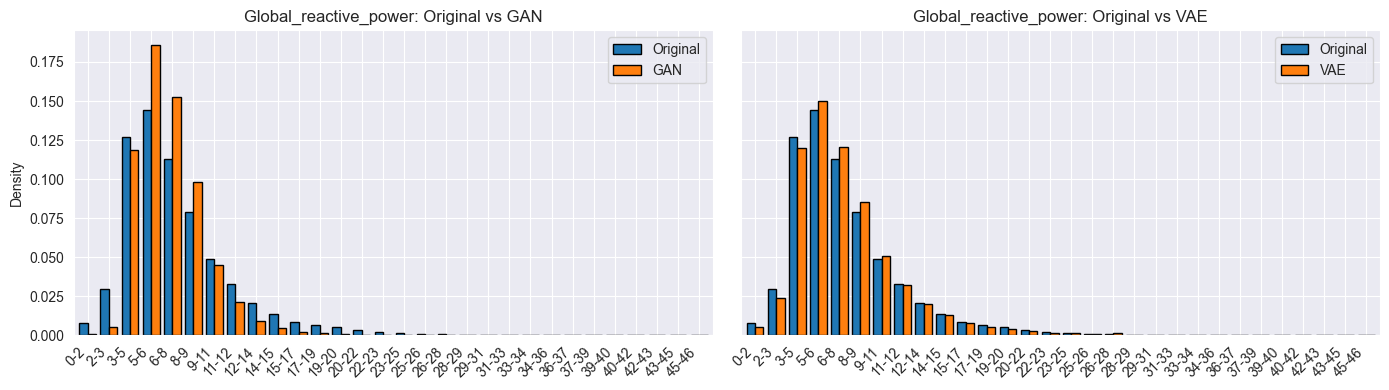

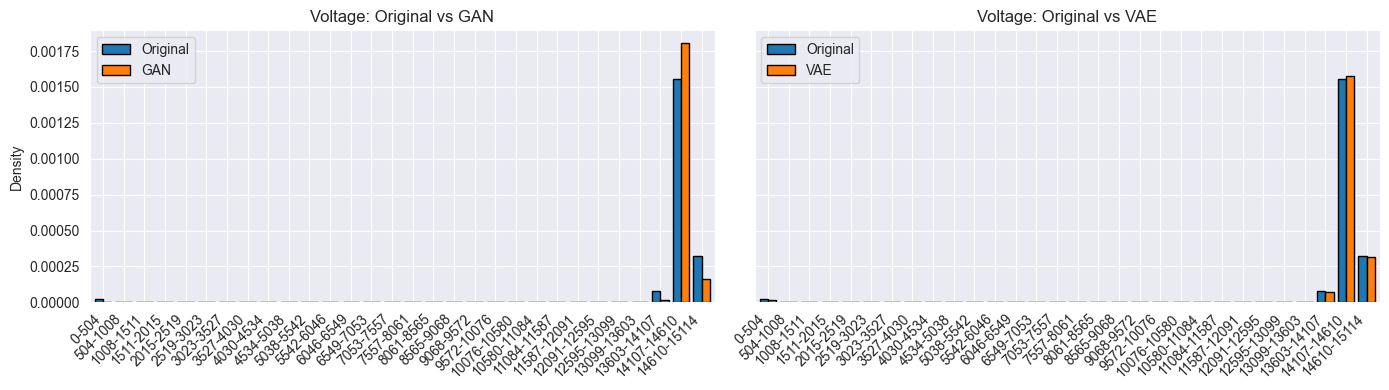

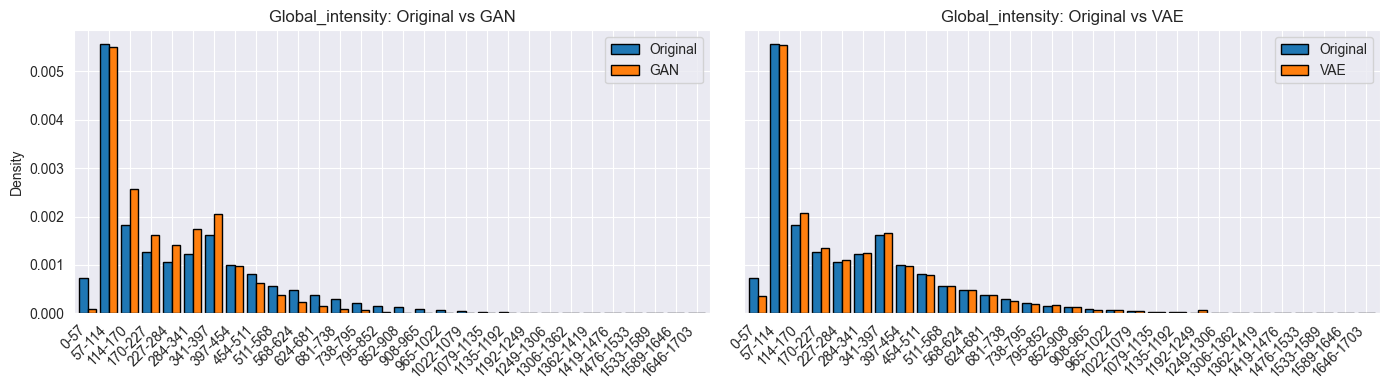

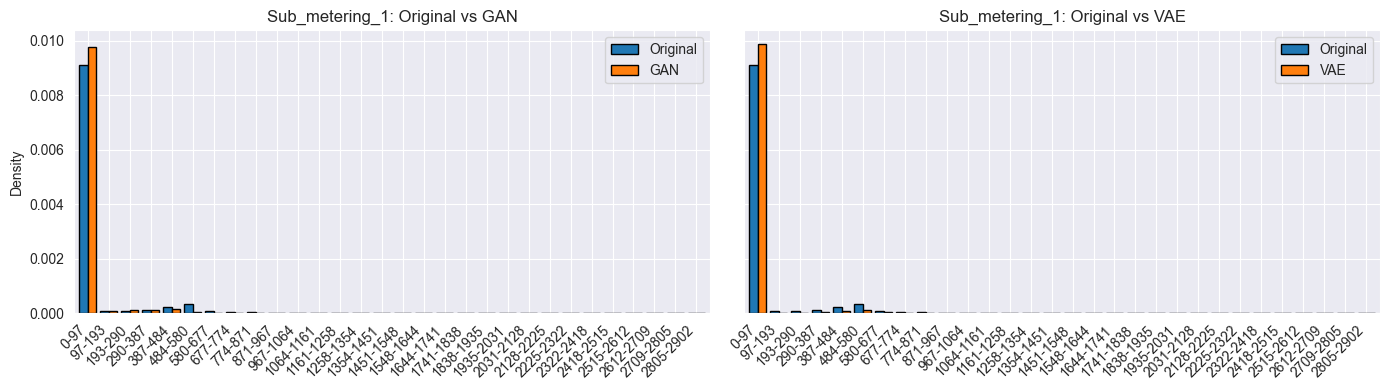

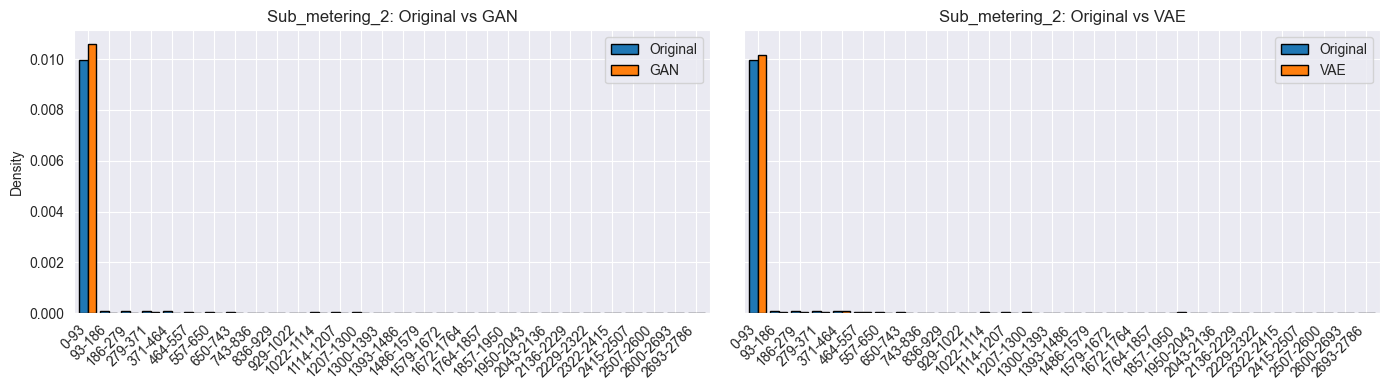

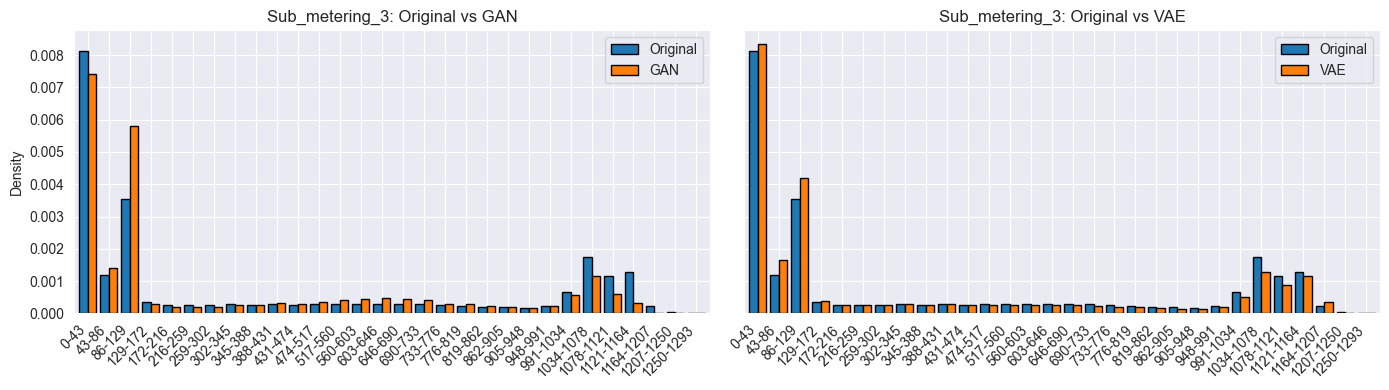

In [8]:
for col in [
    key
    for key, value in household_dataset_metadata.items()
    if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
]:
    orig_vals = household_dataset[col].dropna().values
    gan_vals = S_gan_full[col].dropna().values
    vae_vals = S_vae_full[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts, _ = np.histogram(gan_vals, bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins) - 1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({"Original": orig_counts, "GAN": gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({"Original": orig_counts, "VAE": vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind="bar", ax=axes[0], width=0.8, edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Density")

    df_ov.plot(kind="bar", ax=axes[1], width=0.8, edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.legend()
    plt.tight_layout()
    plt.show()

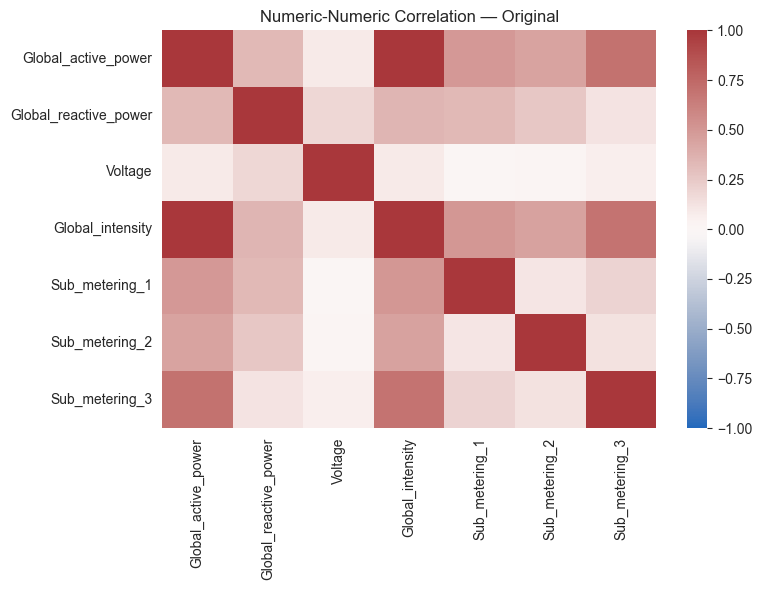

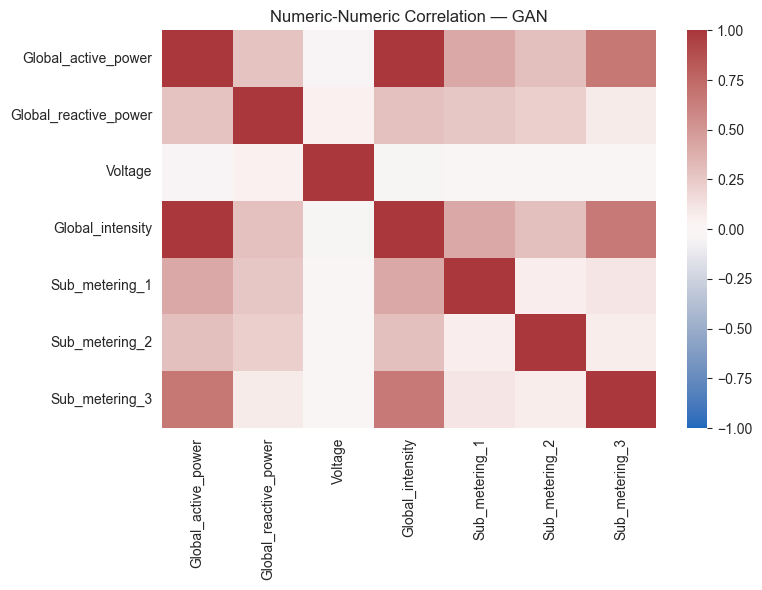

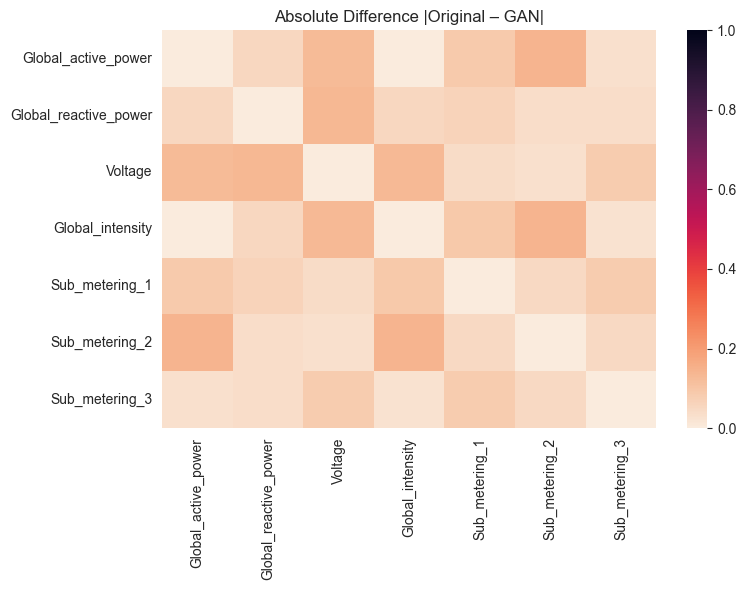

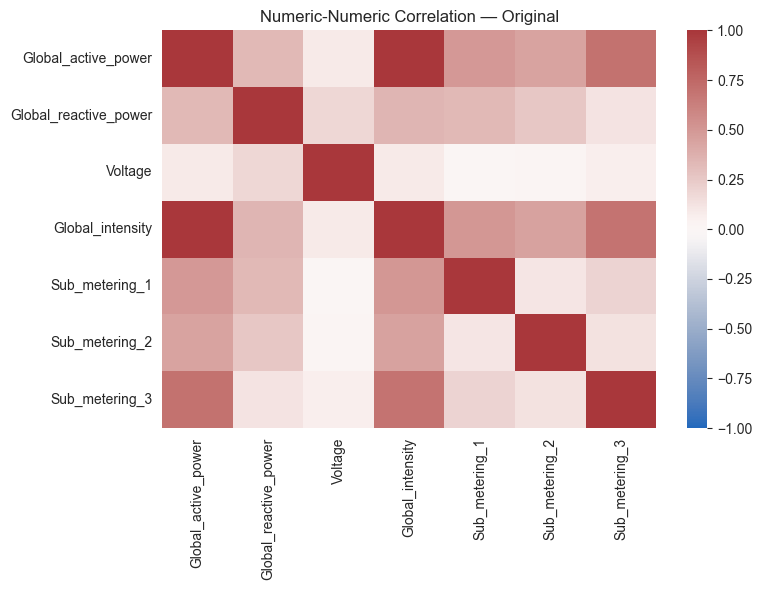

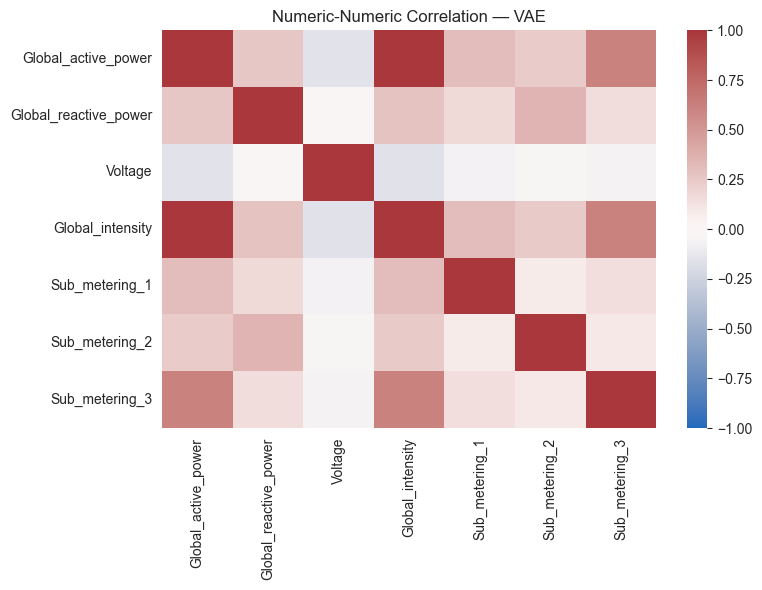

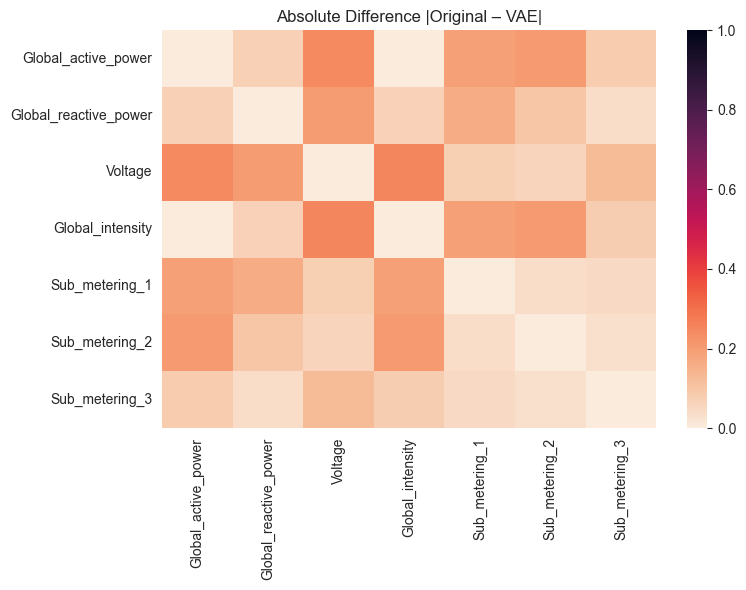

In [11]:
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_gan_full,
    [
        key
        for key, value in household_dataset_metadata.items()
        if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
    ],
    "GAN",
)
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_vae_full,
    [
        key
        for key, value in household_dataset_metadata.items()
        if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
    ],
    "VAE",
)

## Short‑Term Forecasting with ARIMA

### Load & pre-process the real series

In [92]:
DATE_COL = "Date_time"
TARGET_COL = "Global_active_power"
FORECAST_H = 24 * 7
PREPEND_FRAC = 0.15

real_y = (
    household_dataset.set_index(DATE_COL)[TARGET_COL]
    .asfreq("h")
    .interpolate("time")
    .astype("float32")
    .rename("y")
)

# Train / test split
test_y = real_y.tail(FORECAST_H)
train_y = real_y.iloc[:-FORECAST_H]

In [215]:
def build_synth_history(
    df_syn: pd.DataFrame, n_points: int, start_ts: pd.Timestamp
) -> pd.Series:
    """Take the first n_points synthetic values and place them BEFORE start_ts."""
    y_syn = df_syn[TARGET_COL].astype("float32").values[:n_points]
    idx = pd.date_range(
        end=start_ts - pd.Timedelta(hours=1), periods=n_points, freq="h"
    )
    return pd.Series(y_syn, index=idx, name="y")


n_prepend = int(len(train_y) * PREPEND_FRAC)
gan_hist = build_synth_history(S_gan_full, n_prepend, train_y.index[0])
vae_hist = build_synth_history(S_vae_full, n_prepend, train_y.index[0])

variants = {
    "Real": train_y,
    "Real+GAN": pd.concat([gan_hist, train_y]).asfreq("h").interpolate("time"),
    "Real+VAE": pd.concat([vae_hist, train_y]).asfreq("h").interpolate("time"),
}

##### Forecast with 3 datasets

In [217]:
def sf_fit_predict(
    ts: pd.Series, season_len: int = 24, h: int = FORECAST_H, uid: str = "ts"
) -> pd.Series:

    df_train = ts.reset_index()
    df_train.columns = ["ds", "y"]
    df_train["unique_id"] = uid

    model = AutoARIMA(
        season_length=season_len,
        d=1,
        D=1,
        max_p=3,
        max_q=3,
        max_P=1,
        max_Q=1,
        max_order=8,
        method="css",
        approximation=True,
        seasonal_test="ocsb",
        stepwise=True,
    )

    sf = StatsForecast(models=[model], freq="h", n_jobs=1).fit(df_train)
    fc_df = sf.predict(h, level=[80, 95])
    fc = fc_df.set_index("ds")["AutoARIMA"].rename(None)
    return fc.set_axis(test_y.index)


forecasts = {
    name: sf_fit_predict(series, uid=name) for name, series in variants.items()
}

##### Display metrics for each forecasting
MAPE - mean absolute percentage error

RMSE - root mean square error

In [448]:
def metrics_row(y_true, y_pred):
    return {
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    }


metrics = pd.DataFrame(
    {k: metrics_row(test_y, v) for k, v in forecasts.items()}
).T.round(3)

print("Test-set errors")
display(metrics)

Test-set errors


MAPE    RMSE
Real      1.088  60.658
Real+GAN  0.702  39.399
Real+VAE  0.769  37.534

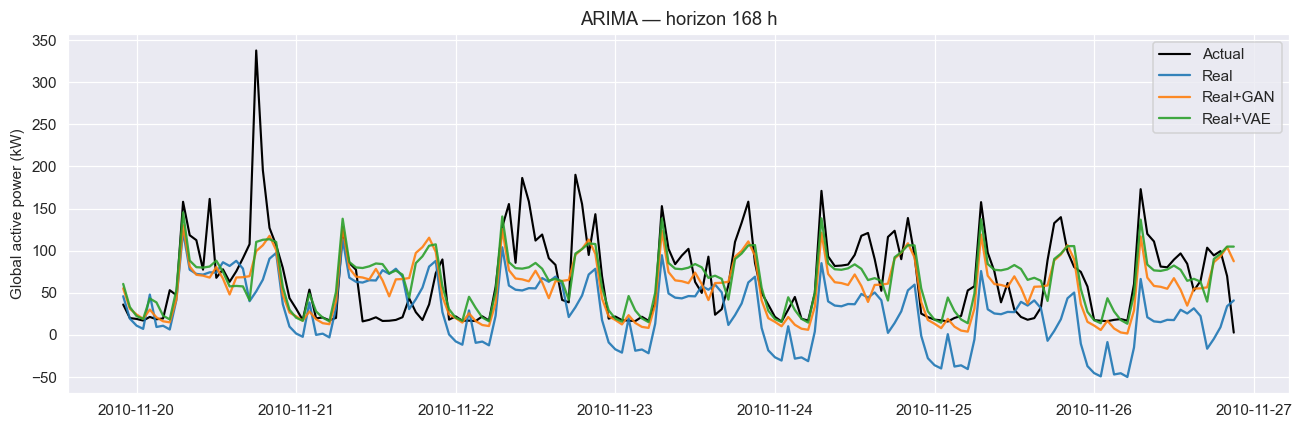

In [449]:
plt.figure(figsize=(12, 4))
plt.plot(test_y, label="Actual", color="k", lw=1.4)
for name, fc in forecasts.items():
    plt.plot(fc, label=name, alpha=0.9)
plt.title(f"ARIMA — horizon {FORECAST_H} h")
plt.ylabel("Global active power (kW)")
plt.legend()
plt.tight_layout()
plt.show()